# Results Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import commonPaths
from collections import OrderedDict
import os

In [2]:
modelNames = ["yolov8n", "yolov8s", "yolov8m", "yolov8l", "yolov8x"]

In [3]:
def providePathsForResultsAnalysis(forTrain):
    '''
        ### providePathsForResultsAnalysis
        provides paths for the results analysis.
        There are different paths whether one wants to preprocess train or val set.
        :param forTrain: defines if paths should be returned for train set. (They will be for val set otherwise)
        :return: dictionary with paths to directories applicable for test or val set
    '''
    paths = {}
    if (forTrain):
        paths["SPEED_RESULTS"] = commonPaths.SPEED_RESULTS_TRAIN_FILE
        paths["MAP_RESULTS_DIR"] = commonPaths.MAP_RESULTS_TRAIN_DIR
    else:
        paths["SPEED_RESULTS"] = commonPaths.SPEED_RESULTS_VAL_FILE
        paths["MAP_RESULTS_DIR"] = commonPaths.MAP_RESULTS_VAL_DIR

    paths["PARAMETERS_DATA"] = commonPaths.PARAMETERS_DATA
    return paths

In [4]:
def readData(modelNames, isTrain=False):
    '''
      ### readData
      reads data about parameters, speed results and mAP from data directory.
      
      :param modelNames: list with the names of models matching those in file names (without .pt)
      :param isTrain: defines if data should be returned for train set. (The data will be for val set otherwise)
      :return parametersData: DataFrame with YOLO model name and number of parameters in Millions
      :return speedResults: DataFrame with YOLO model name and time needed for making predictions in seconds.
      :return mAPResults: Dictionary where: Key=YOLO model name, Value=DataFrame with 2 columns: Category and Average Precision
    '''
    paths = providePathsForResultsAnalysis(isTrain)
    parametersData = pd.read_csv(paths["PARAMETERS_DATA"], index_col=0)
    parametersData.columns = ["Parameters (M)"]
    speedResults = pd.read_csv(paths["SPEED_RESULTS"], index_col=0)
    speedResults.columns = ["Time (sec)"]
    mAPResults = OrderedDict().fromkeys(modelNames)
    for file in os.listdir(paths["MAP_RESULTS_DIR"]):
       name = file.split("_")[-1].split(".")[0]
       mAP = pd.read_csv(paths["MAP_RESULTS_DIR"]+file, header=None)
       mAP.columns = ["Category", "Average Precision"]
       mAPResults[name] = mAP
    return parametersData, speedResults, mAPResults

In [5]:
def calculateMAP(mAPResults):
    '''
        ### calculateMAP
        calculates mAP over all classes for each model and creates a dictionary.

        :param mAPResults: Dictionary where: Key=YOLO model name, Value=DataFrame with 2 columns: Category and Average Precision
        :return: Series where: index=YOLO model name, Value=mAP averaged over all classes
    '''
    mAPs = OrderedDict()
    for name, result in mAPResults.items():
        mAPs[name] = result.iloc[:,-1].sum() / result.shape[0]
    return pd.Series(mAPs).rename("mAP@0.5:0.05:0.95")

In [6]:
def createAllInOneFrame(mAPResults):
    '''
        ### createAllInOneFrame
        creates bigger data frame which contains categoryNames and mAP results for each model.

        :param mAPResults: Dictionary where: Key=YOLO model name, Value=DataFrame with 2 columns: Category and Average Precision
        :return: DataFrame with 6 columns: Category and 5 columns with APs for each model. There are as many rows
        as classes
    '''
    allInOne = mAPResults["yolov8n"].copy()
    categoryColumnName = allInOne.columns[0]
    columnNames = [categoryColumnName, "yolov8n"]
    allInOne.columns = columnNames
    for name, mAPResult in mAPResults.items():
        if(name == "yolov8n"):
            continue
        allInOne[name] = mAPResult.iloc[:,1]
    return allInOne

In [7]:
parametersDataVal, speedResultsVal, mAPResultsVal = readData(modelNames)
parametersDataTrain, speedResultsTrain, mAPResultsTrain = readData(modelNames, isTrain=True)

In [8]:
mAPsVal = calculateMAP(mAPResultsVal)
mAPsTrain = calculateMAP(mAPResultsTrain)

In [9]:
allAPsInOneVal = createAllInOneFrame(mAPResultsVal)
allAPsInOneTrain = createAllInOneFrame(mAPResultsTrain)

In [10]:
def generateBarPlots(parametersData, speedResults, mAPs, isTrain=False):
    '''
        ### generateBarPlots
        creates 3 bar plots presenting the values of number of parameters, time needed for predictions and mAPs
        for each model.

        :param parametersData: DataFrame with YOLO model name and number of parameters in Millions
        :param speedResults: DataFrame with YOLO model name and time needed for making predictions in seconds.
        :param mAPs: Series where: index=YOLO model name, Value=mAP averaged over all classes
        :param isTrain: defines if the data is for Train set (for plot's title)
    '''
    plt.figure(figsize=(10,5))
    if(isTrain):
        plt.suptitle("Results for Training set")   
    else:
        plt.suptitle("Results for Validation set")
    plt.subplot(1,3,1)
    plt.barh(parametersData.index, parametersData.iloc[:,0])
    plt.xlabel(parametersData.columns[0])
    plt.title("Parameters count")

    plt.subplot(1,3,2)
    plt.barh(speedResults.index, speedResults.iloc[:,0])
    plt.xlabel(speedResults.columns[0])
    plt.title("Time needed for making predictions")

    plt.subplot(1,3,3)
    plt.barh(mAPs.index, mAPs)
    plt.xlabel(mAPs.name)
    plt.title("Mean Average Precision")
    
    plt.tight_layout()
    plt.show()

In [11]:
def generateBarPlotsForCategories(mAPResults, isTrain=False):
    '''
        ### generateBarPlotsForCategories
        creates n (number of models) bar plots presenting AP for each category. The data is presented
        in descending order

        :param mAPResults: Dictionary where: Key=YOLO model name, Value=DataFrame with 2 columns: Category and Average Precision
        :param isTrain: defines if the data is for Train set (for plot's title)
    '''
    if(isTrain):
        title = "Average Precision per class for Training set for the model: "
    else:
        title = "Average Precision per class for Validation set for the model: "
    for name, mAPResult in mAPResults.items():
        plt.figure(figsize=(15,15))
        plt.margins(y=0)
        sortedFrame = mAPResult.sort_values(by="Average Precision")
        plt.barh(sortedFrame.iloc[:,0], sortedFrame.iloc[:,1], height=0.8, align="center")
        plt.title(title + name)
        plt.tight_layout()
        plt.show()

In [12]:
def generateLinePlots(parametersData, speedResults, mAPs, isTrain=False):
    '''
        ### generateLinePlots
        Generates 2 line plots: mAP vs parameters and mAP vs time
        Single point in a single model

        :param parametersData: DataFrame with YOLO model name and number of parameters in Millions
        :param speedResults: DataFrame with YOLO model name and time needed for making predictions in seconds.
        :param mAPs: Series where: index=YOLO model name, Value=mAP averaged over all classes
        :param isTrain: defines if the data is for Train set (for plot's title)
    '''
    if(isTrain):
        title = "Training set"
    else:
        title = "Validation set"
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(parametersData.iloc[:,0], mAPs, marker="o")
    x = parametersData.iloc[:,0]
    y = mAPs
    for i, name in enumerate(mAPs.index):
        plt.text(x.iloc[i] + 0.05 * x.iloc[i], y.iloc[i] - 0.01 * y.iloc[i], f'{name}', fontsize=10, color="magenta")

    plt.xlabel(parametersData.columns[0])
    plt.ylabel(mAPs.name)
    plt.grid(True)
    plt.title("mAP vs parameters")

    plt.subplot(1,2,2)
    plt.plot(speedResults.iloc[:,0], mAPs, marker="o")
    x = speedResults.iloc[:,0]
    y = mAPs
    for i, name in enumerate(mAPs.index):
        plt.text(x.iloc[i] + 0.05 * x.iloc[i] , y.iloc[i] - 0.01 * y.iloc[i], f'{name}', fontsize=10, color="magenta")

    plt.xlabel(speedResults.columns[0])
    plt.ylabel(mAPs.name)
    plt.grid(True)
    plt.title("mAP vs time")

    plt.suptitle(title)
    plt.tight_layout()

In [18]:
def plotLinePlotsForCategories(parametersData, allAPsInOne, isTrain=False):
    '''
        ### plotLinePlotsForCategories
        Generates AP vs model line plots. Currently there are 7 lines on a single graph, each for a single
        category. There are as many plots as numberOfCategories/7

        :param parametersData: DataFrame with YOLO model name and number of parameters in Millions
        :param allAPsInOne: DataFrame with 6 columns: Category and 5 columns with APs for each model. There are as
        many rows as classes
        :param isTrain: defines if the data is for Train set (for plot's title)
    '''
    if(isTrain):
        title = "APs for category vs models. Training set. Categories "
    else:
        title = "APs for category vs models. Validation set. Categories "
    numberOfRows = int(np.ceil(allAPsInOne.shape[0] / 7))
    for i in range(0, numberOfRows, 2):
        plt.figure(figsize=(15,7))
        currentAPs = allAPsInOne.iloc[i*7:(i+1)*7, :]
        names = currentAPs.iloc[:, 0]
        minId = str(names.index.min())

        plt.subplot(1, 2, 1)
        for j in range(0,len(names)):
            plt.plot(parametersData.index, currentAPs.iloc[j,1:], marker="o", label=names[7*i+j])
        plt.ylim(0,1)
        plt.legend()

        currentAPs = allAPsInOne.iloc[(i+1)*7:(i+2)*7, :]
        names = currentAPs.iloc[:, 0]
        maxId = str(names.index.max())

        plt.subplot(1, 2, 2)
        for j in range(0,len(names)):
            plt.plot(parametersData.index, currentAPs.iloc[j,1:], marker="o", label=names[7*(i+1)+j])
        plt.ylim(0,1)
        plt.legend()

        plt.suptitle(title + minId +" to " + maxId)
        plt.show()

## Training Set Analysis

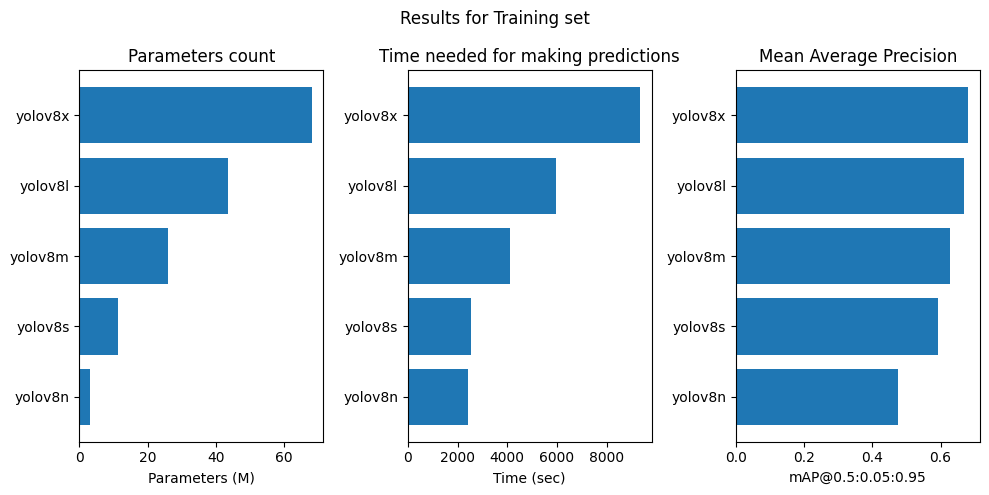

In [14]:
generateBarPlots(parametersDataTrain, speedResultsTrain, mAPsTrain, isTrain=True)

### Conclusions after analysis of bar plot analysis for training set:
* The complexity of the model increases greatly with each of them
* The more complex the model, the more time it needs to make predictions (which is no surprise).
* The widths of bars are similar for the parameters and time.
* yolov8n (despite being a lot less complex) needed similar to yolov8s amount of time to complete the task what can be quite astounding.
* the mAP increases the more complex the model. The greatest gap can be seen between yolov8n and yolov8s. Then the differences are smaller, espacially between v8l and v8x
* The largest model needs more than 4 times more time to make the predictions on training dataset (around 2.5 hours on the tested hardware).

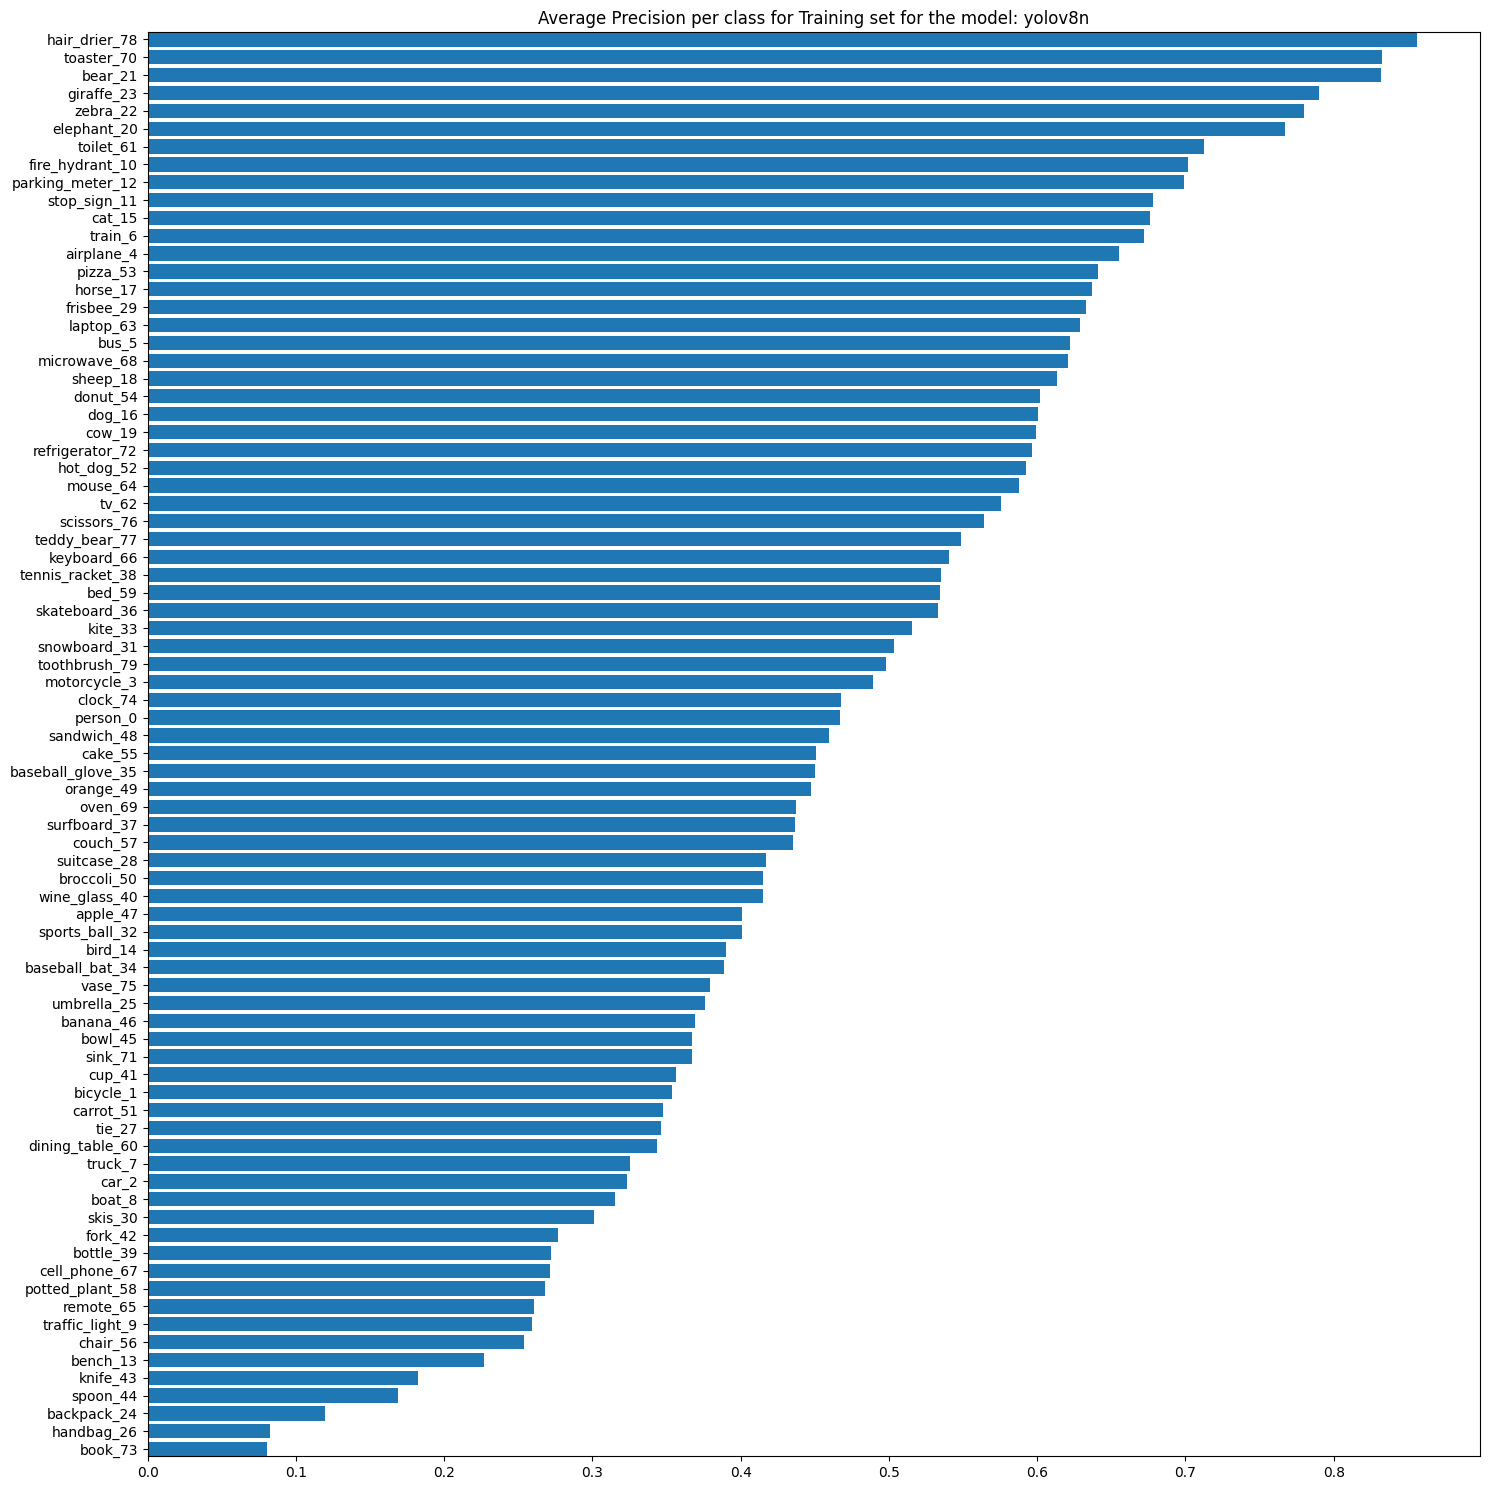

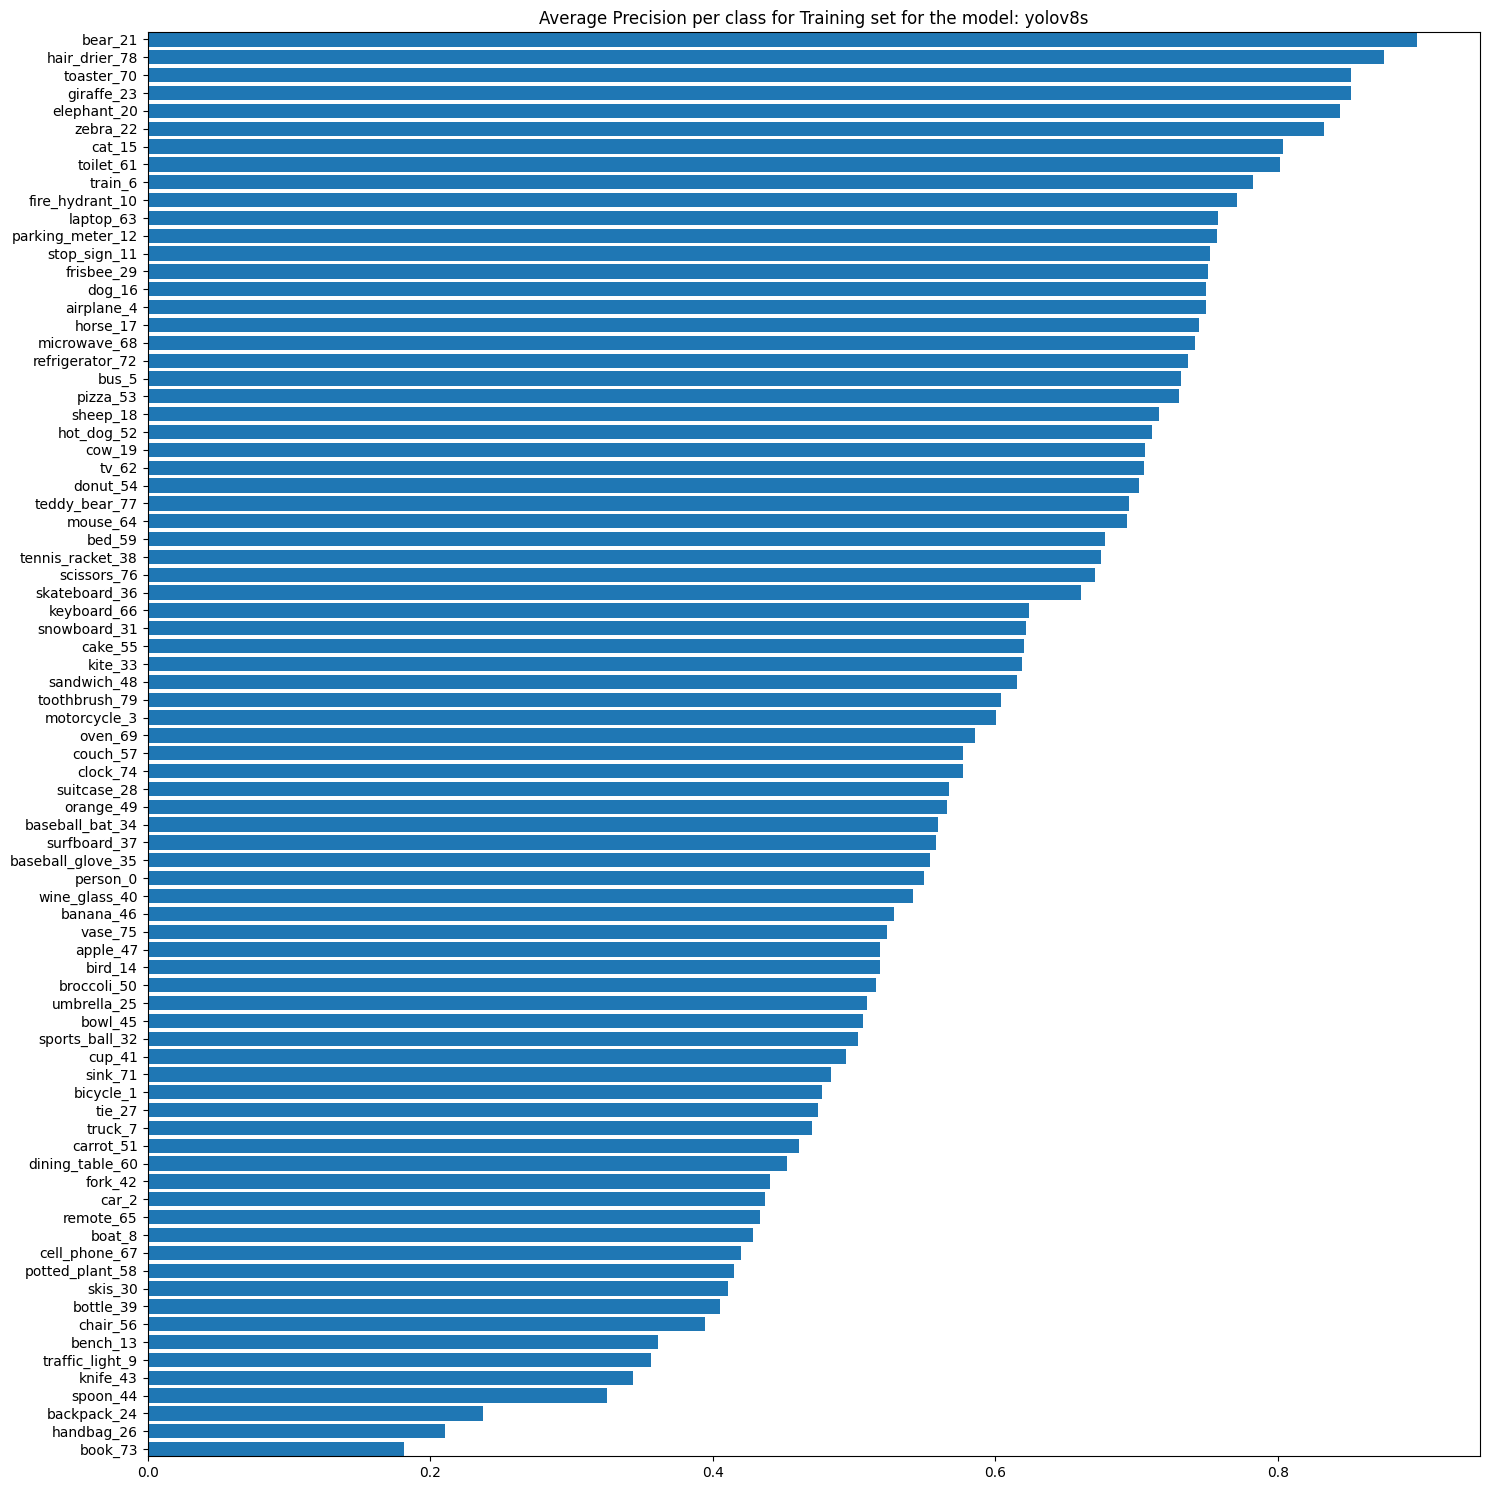

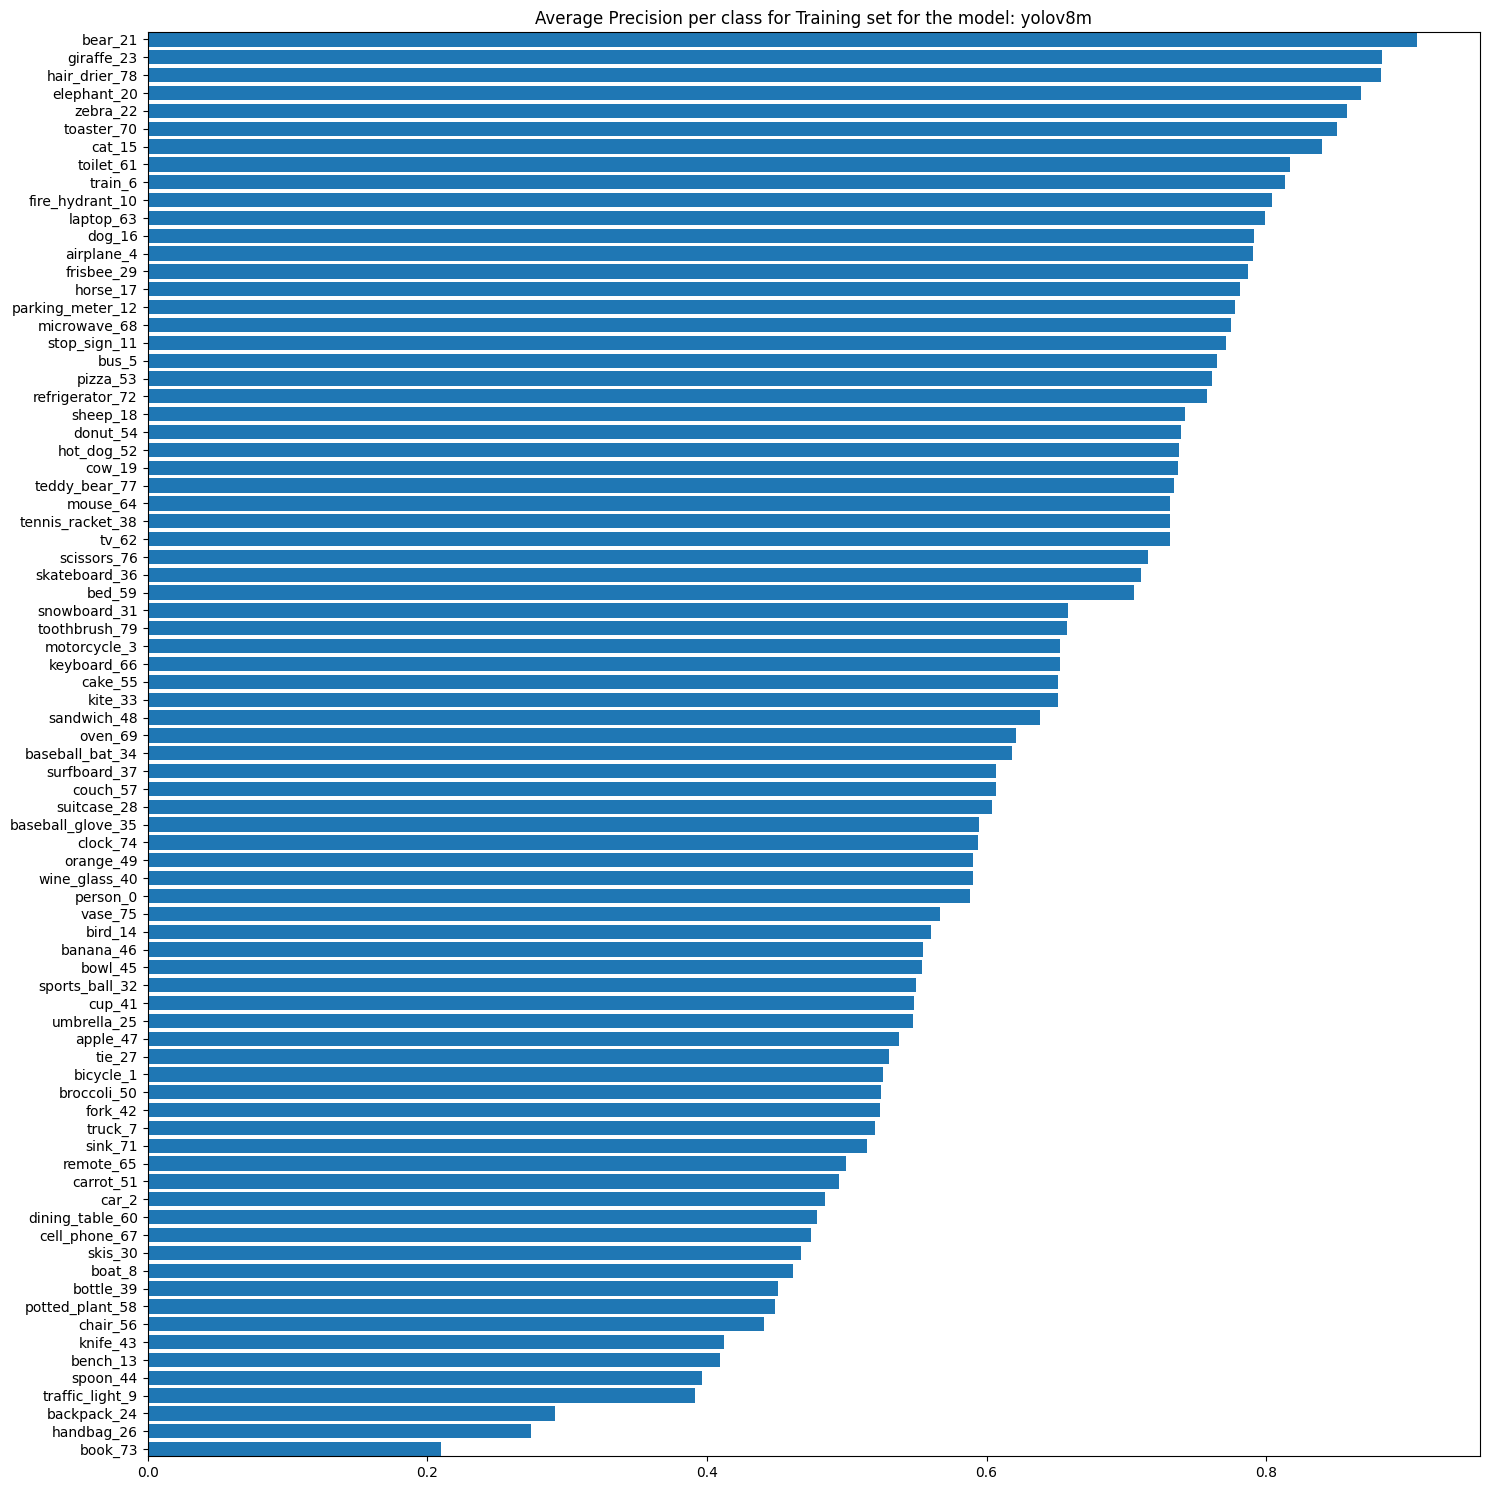

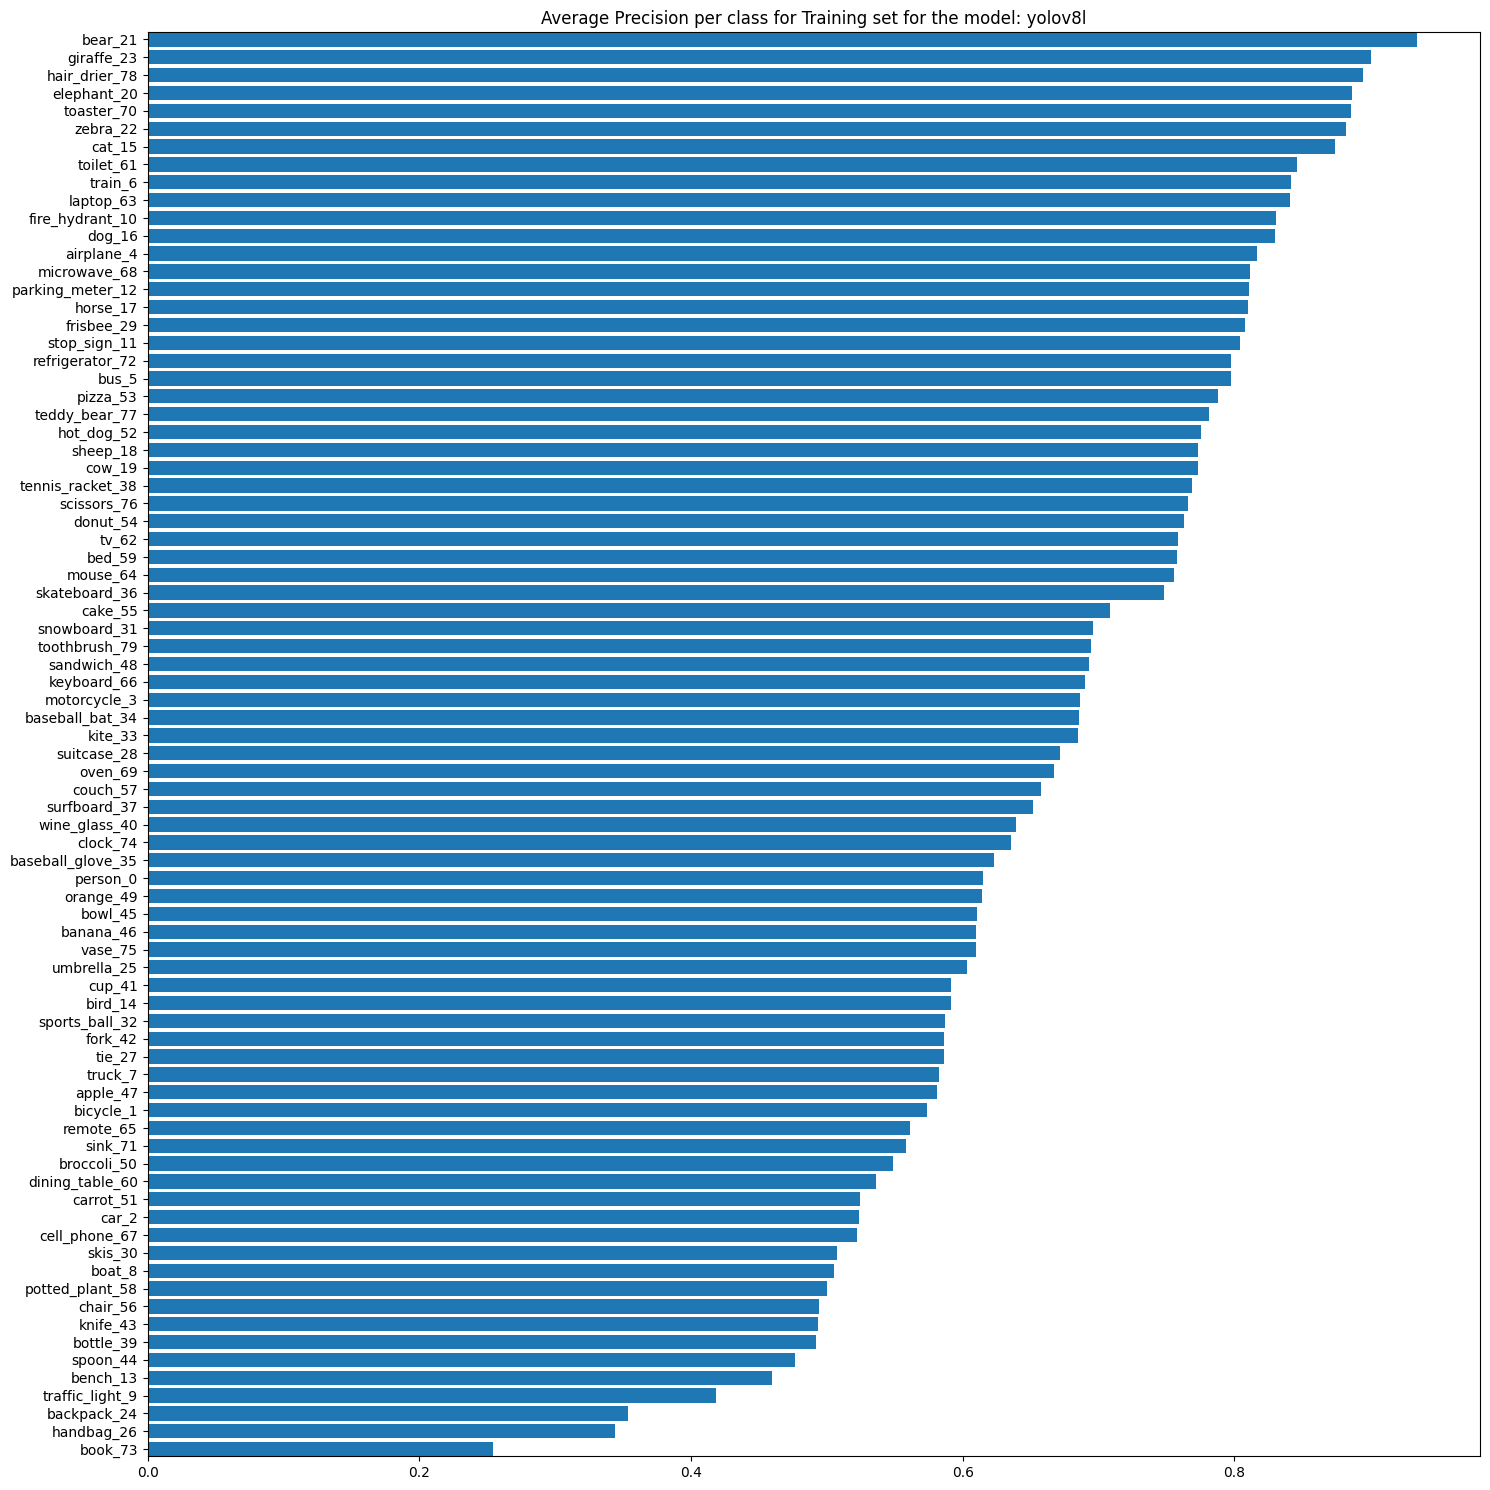

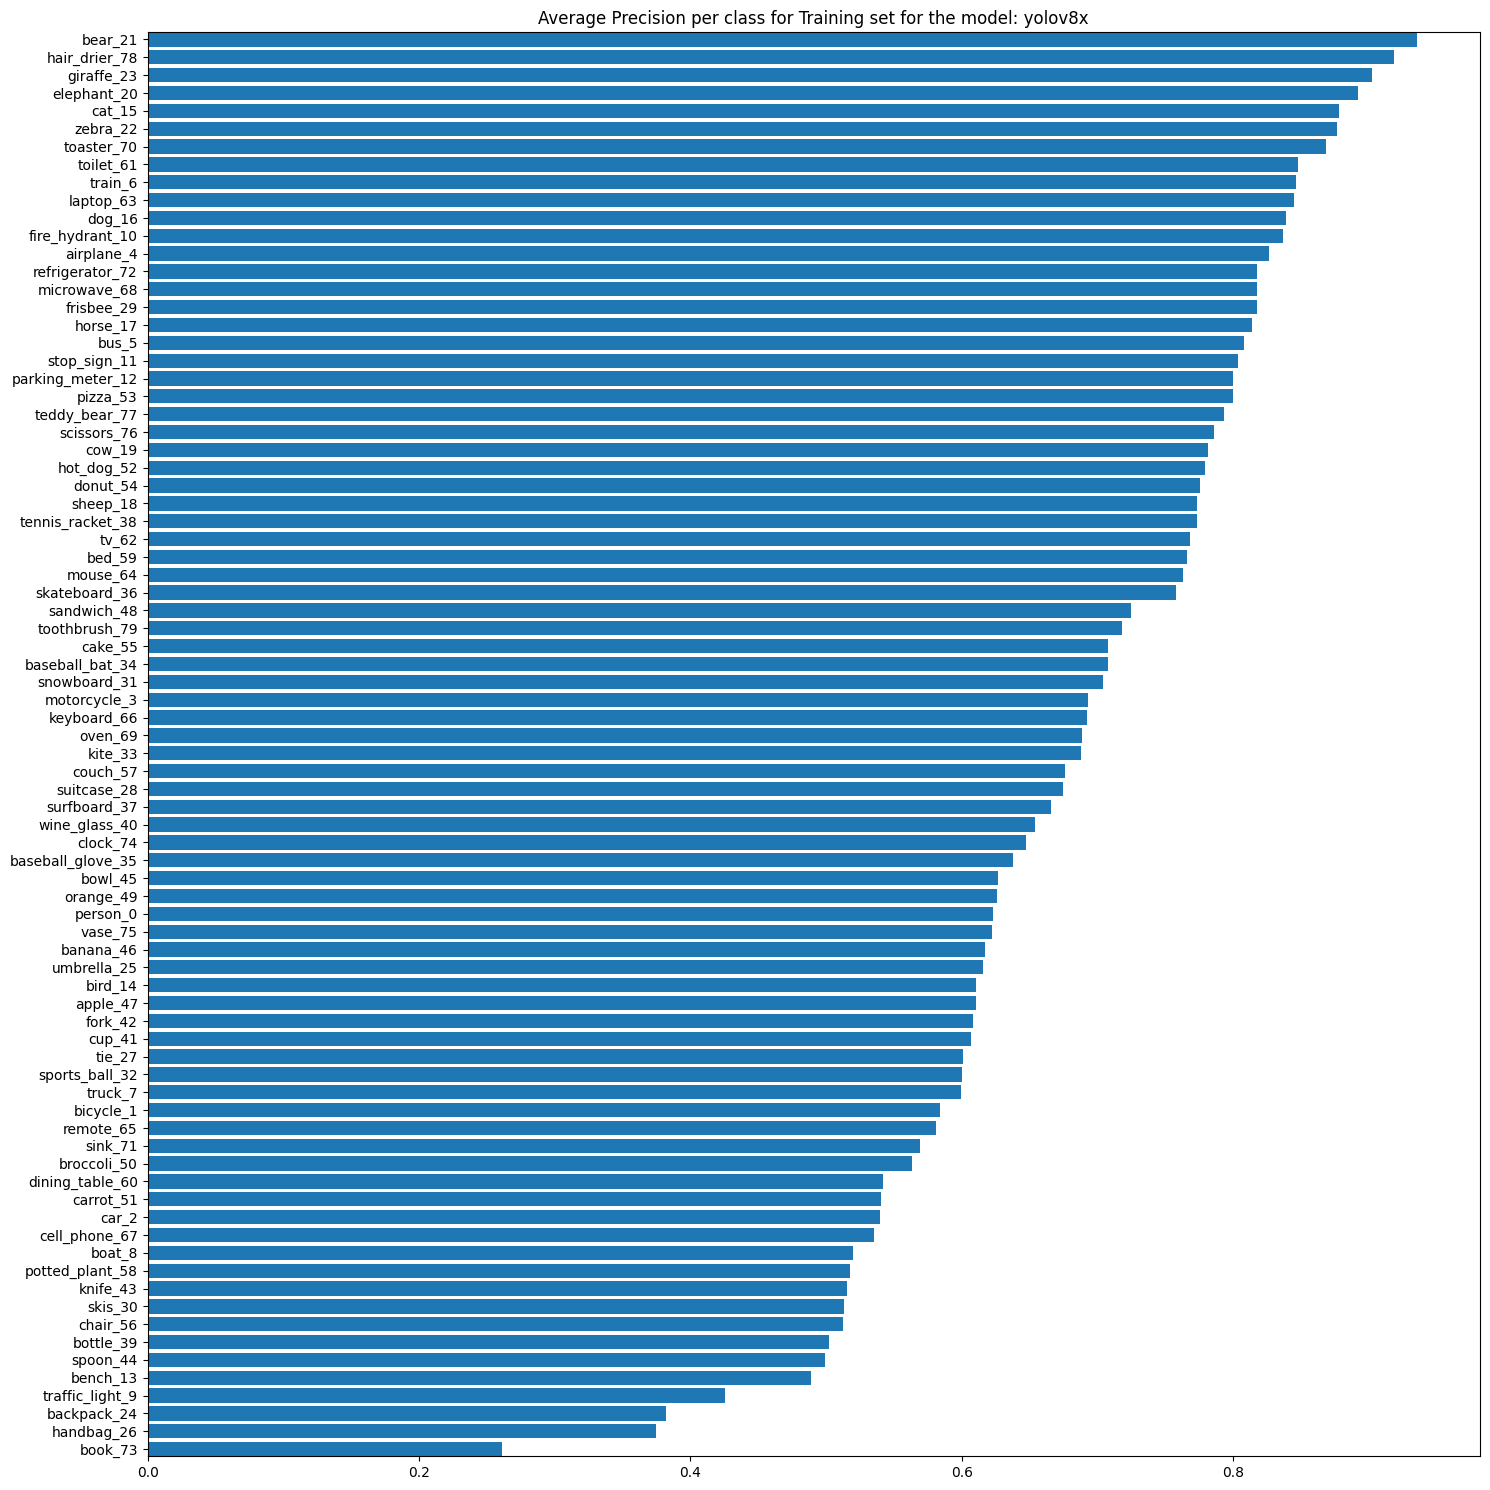

In [15]:
generateBarPlotsForCategories(mAPResultsTrain, isTrain=True)

### Conclusion after analysis of bar AP bar plots per category for training set:
* the models show enormous difference when it comes to accuracy of predictions per class.
* The most difficult objects hava AP at the level of 0.2 while the easiest have around 0.9 mAP.
* The most difficult object are books, handbags and backpacks
* The easiest objects to predict are hair driers, toasters and giant animals like elephants, giraffes and bears.
* AP for the most and the least characteristic objects doesn't change much with the increasing complexity of the model. Increased complexity helps greatly the objects "in the middle" of the chart. For the smallest model their AP is around 0.4 while for the largest it increases to 0.6. 

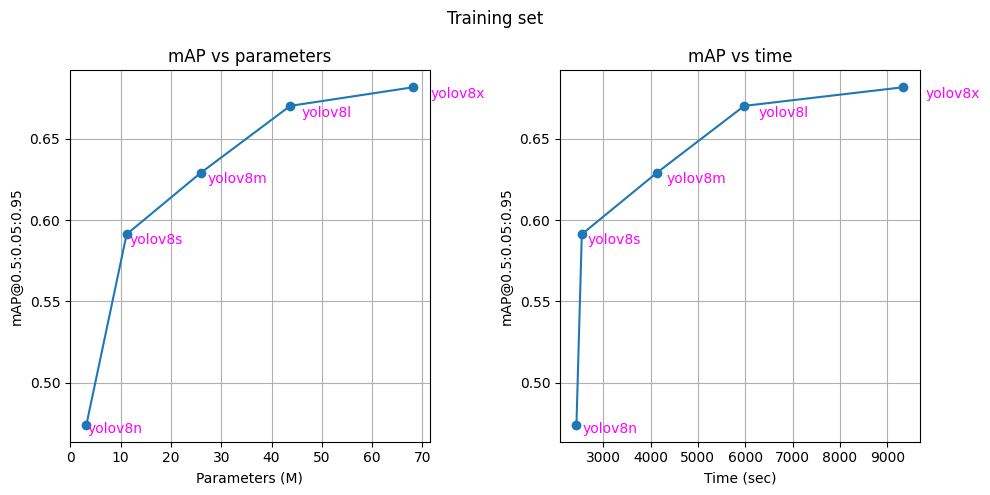

In [16]:
generateLinePlots(parametersDataTrain, speedResultsTrain, mAPsTrain, isTrain=True)

### Conclusions after analysing relation of mAP with parameters and time for training set:
* Here lies another proof that the more complex the model the better the results.
* The difference in accuracy (considering the difference in time) between yolov8n and yolov8s is overwhelming. The v8s presents more than 0.1 higher mAP while the time difference is tiny. It is especially shocking given that the v8s model is 3.5 times more complex! Unless every milisecond counts or computational power is limited, one can say that the choice between v8n and v8s is clear.
* Interestingly, the difference between v8s, v8m and v8l looks linear
* Although yolov8x presents the greatest mAP, the time needed by this model to make predictions may be unacceptable. For many cases, choosing v8x over v8l would be just not worth it since the gain in mAP is small considering the huge gain of time.  

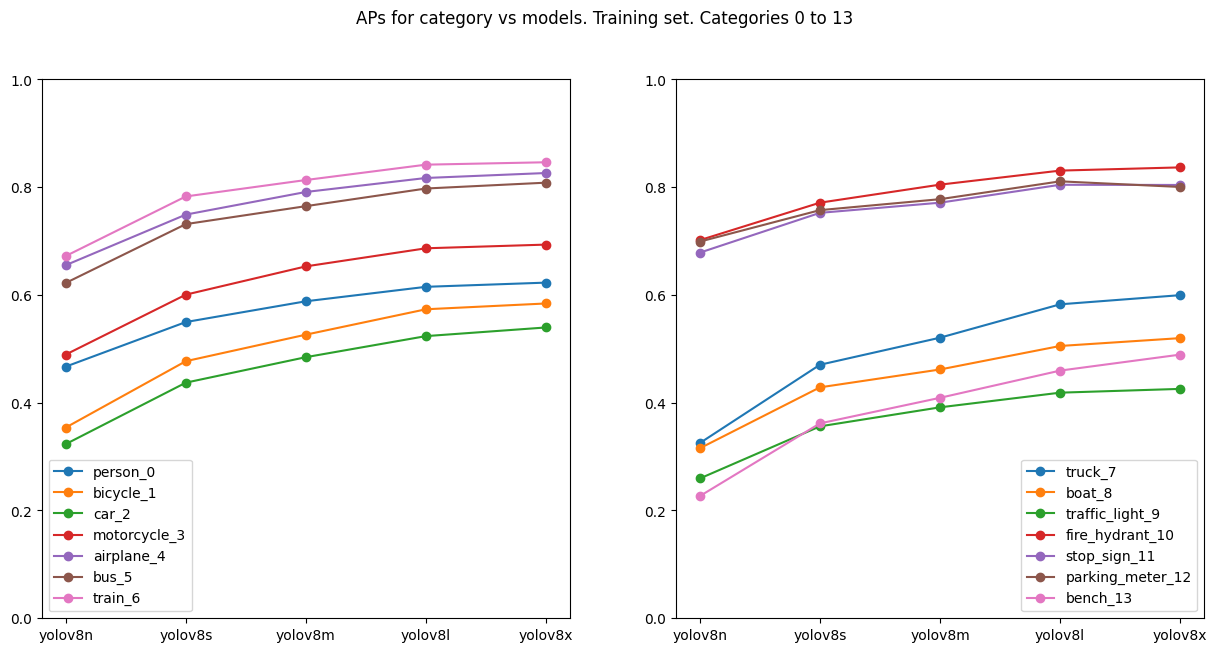

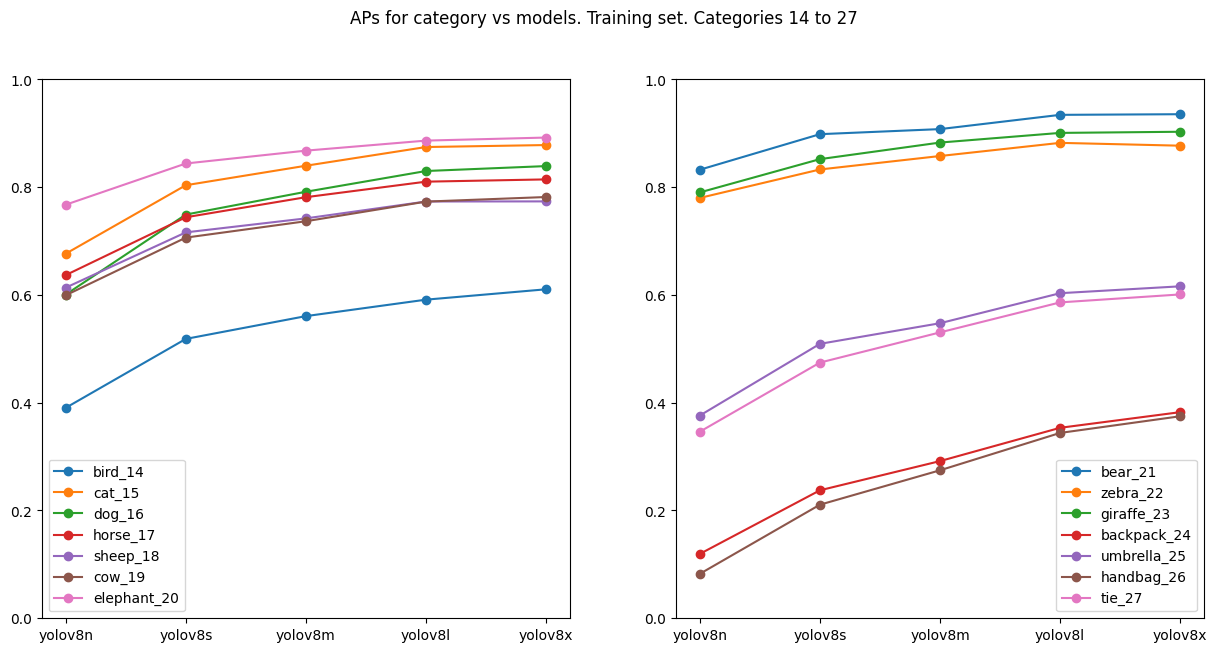

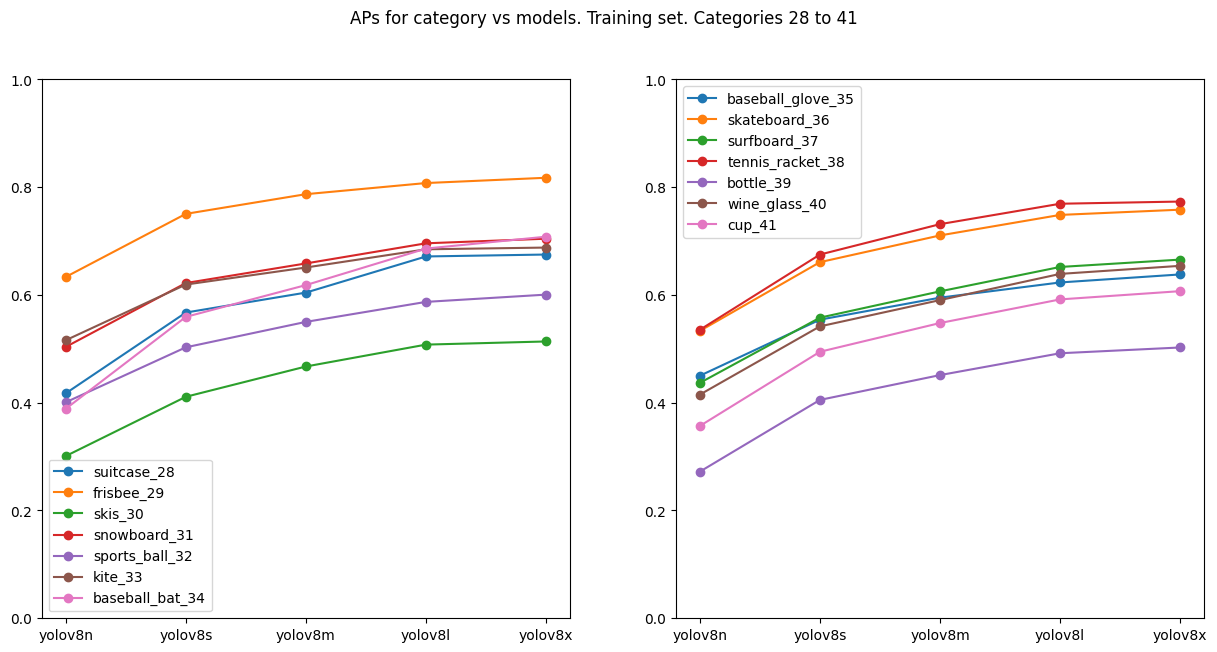

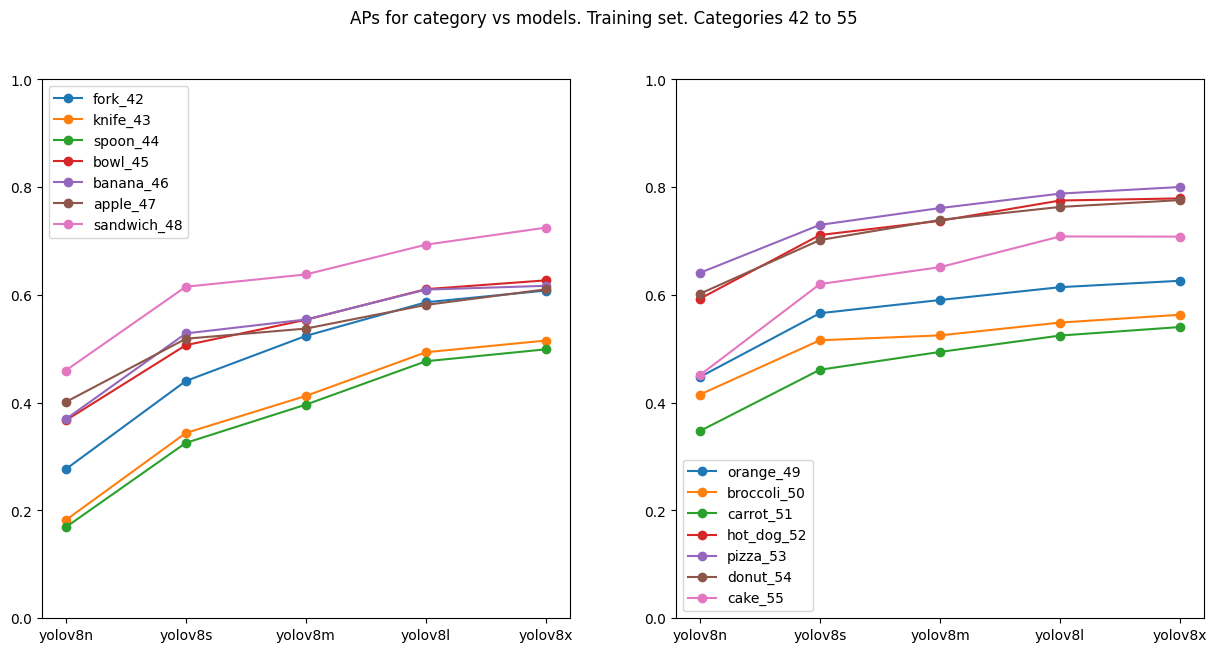

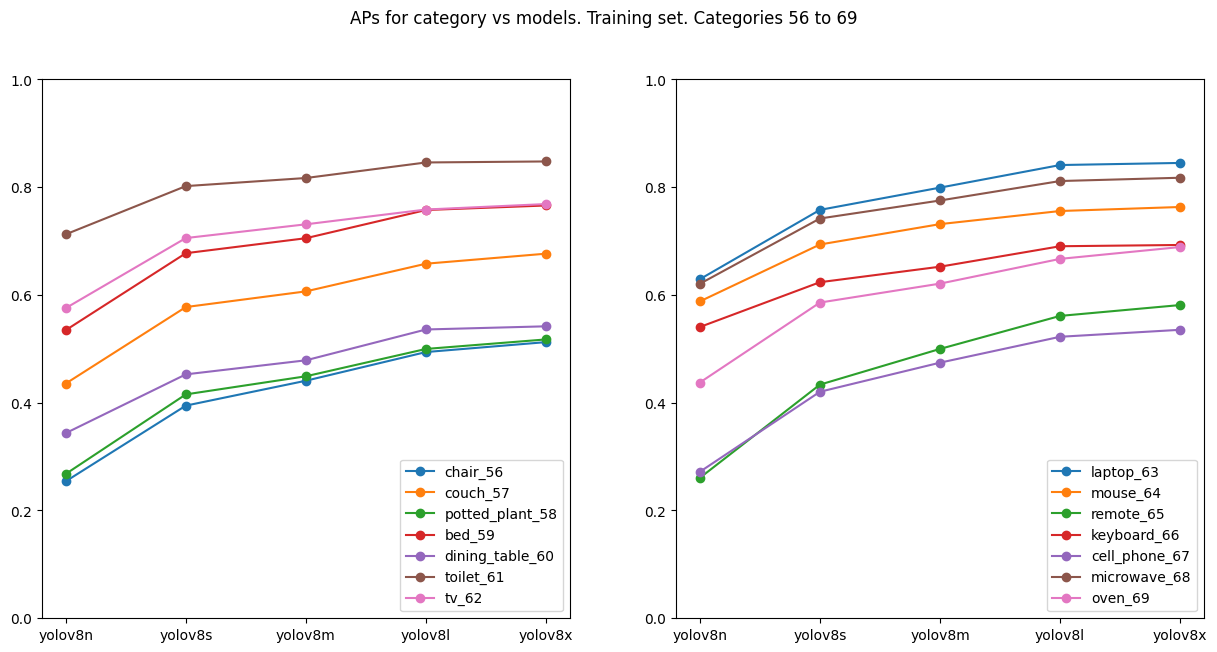

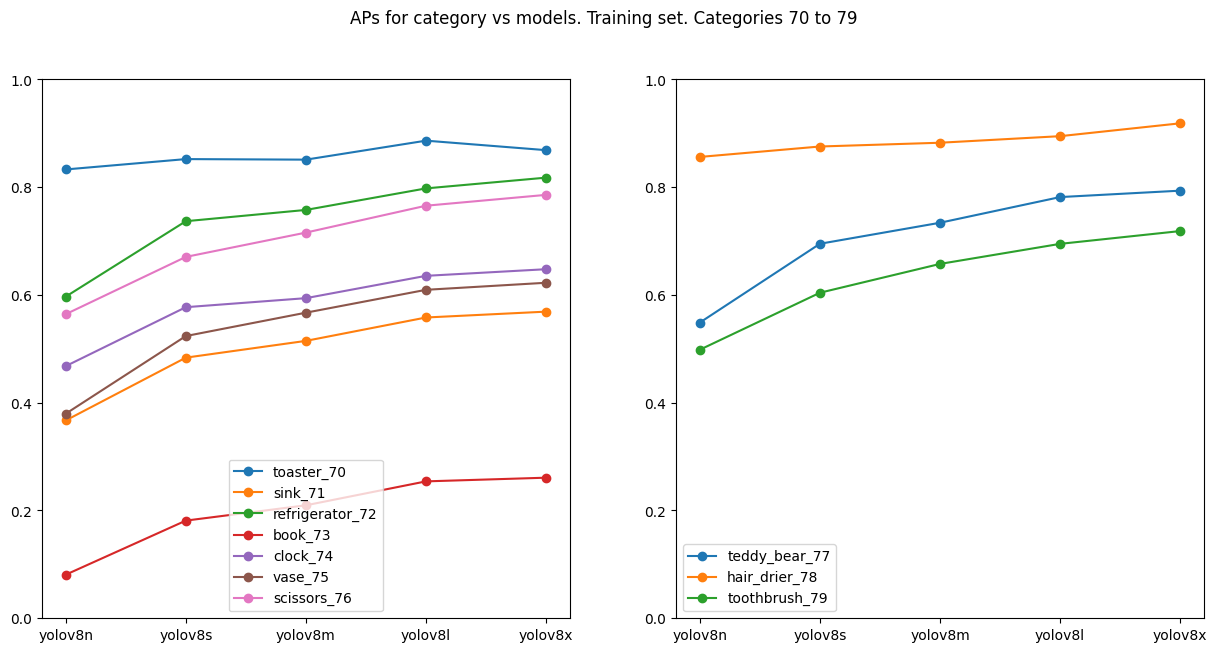

In [19]:
plotLinePlotsForCategories(parametersDataTrain, allAPsInOneTrain, isTrain=True)

### Conclusions after analysing relation of mAP with parameters and time per class for training set:
* Most of the classes follow the general pattern. The curve has three parts, steep one between v8n and v8s, flat between v8l and v8x and linear in the middle
* Knife and spoon presented the biggest gain of mAP while increasing complexity of a model.
* The accuracy for the most characteristic objects does not change much with the increasing model complexity
* There can't be seen any decrease of mAP with increasing complexity of the model. There are few cases where (despite changing the model) mAP remains the same.

## Validation Set Analysis

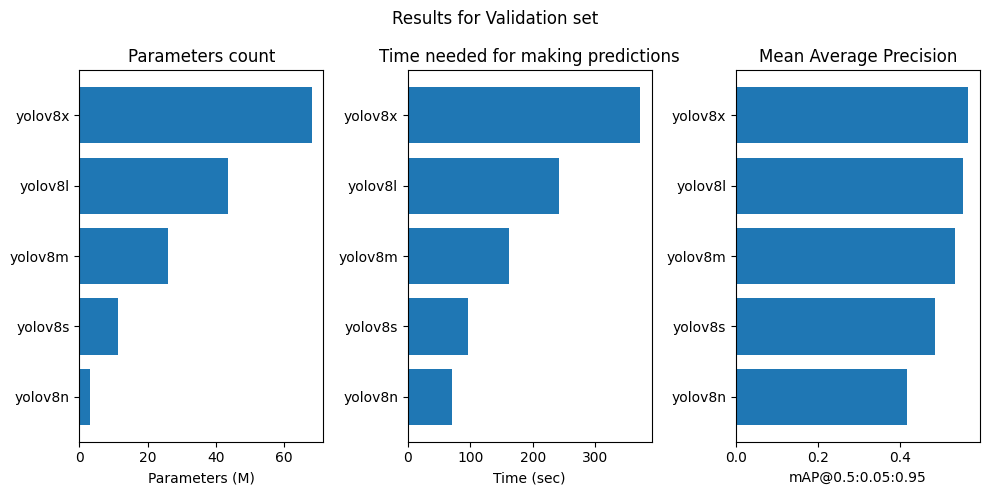

In [20]:
generateBarPlots(parametersDataVal, speedResultsVal, mAPsVal, isTrain=False)

### Conclusions after analysis of bar plot analysis for validation set:
* The trend of time and mAP stays more or less the same for the validation set. The more complex the model, the greatest mAP and the model needs more time to predict
* The models needed proportionally less time (since the dataset is more than 20 times smaller).
* The mAP is lower on the data that the model did not see during the training phase. It drops from around 0.68 to around 0.56 for the v8x model. This result was expected

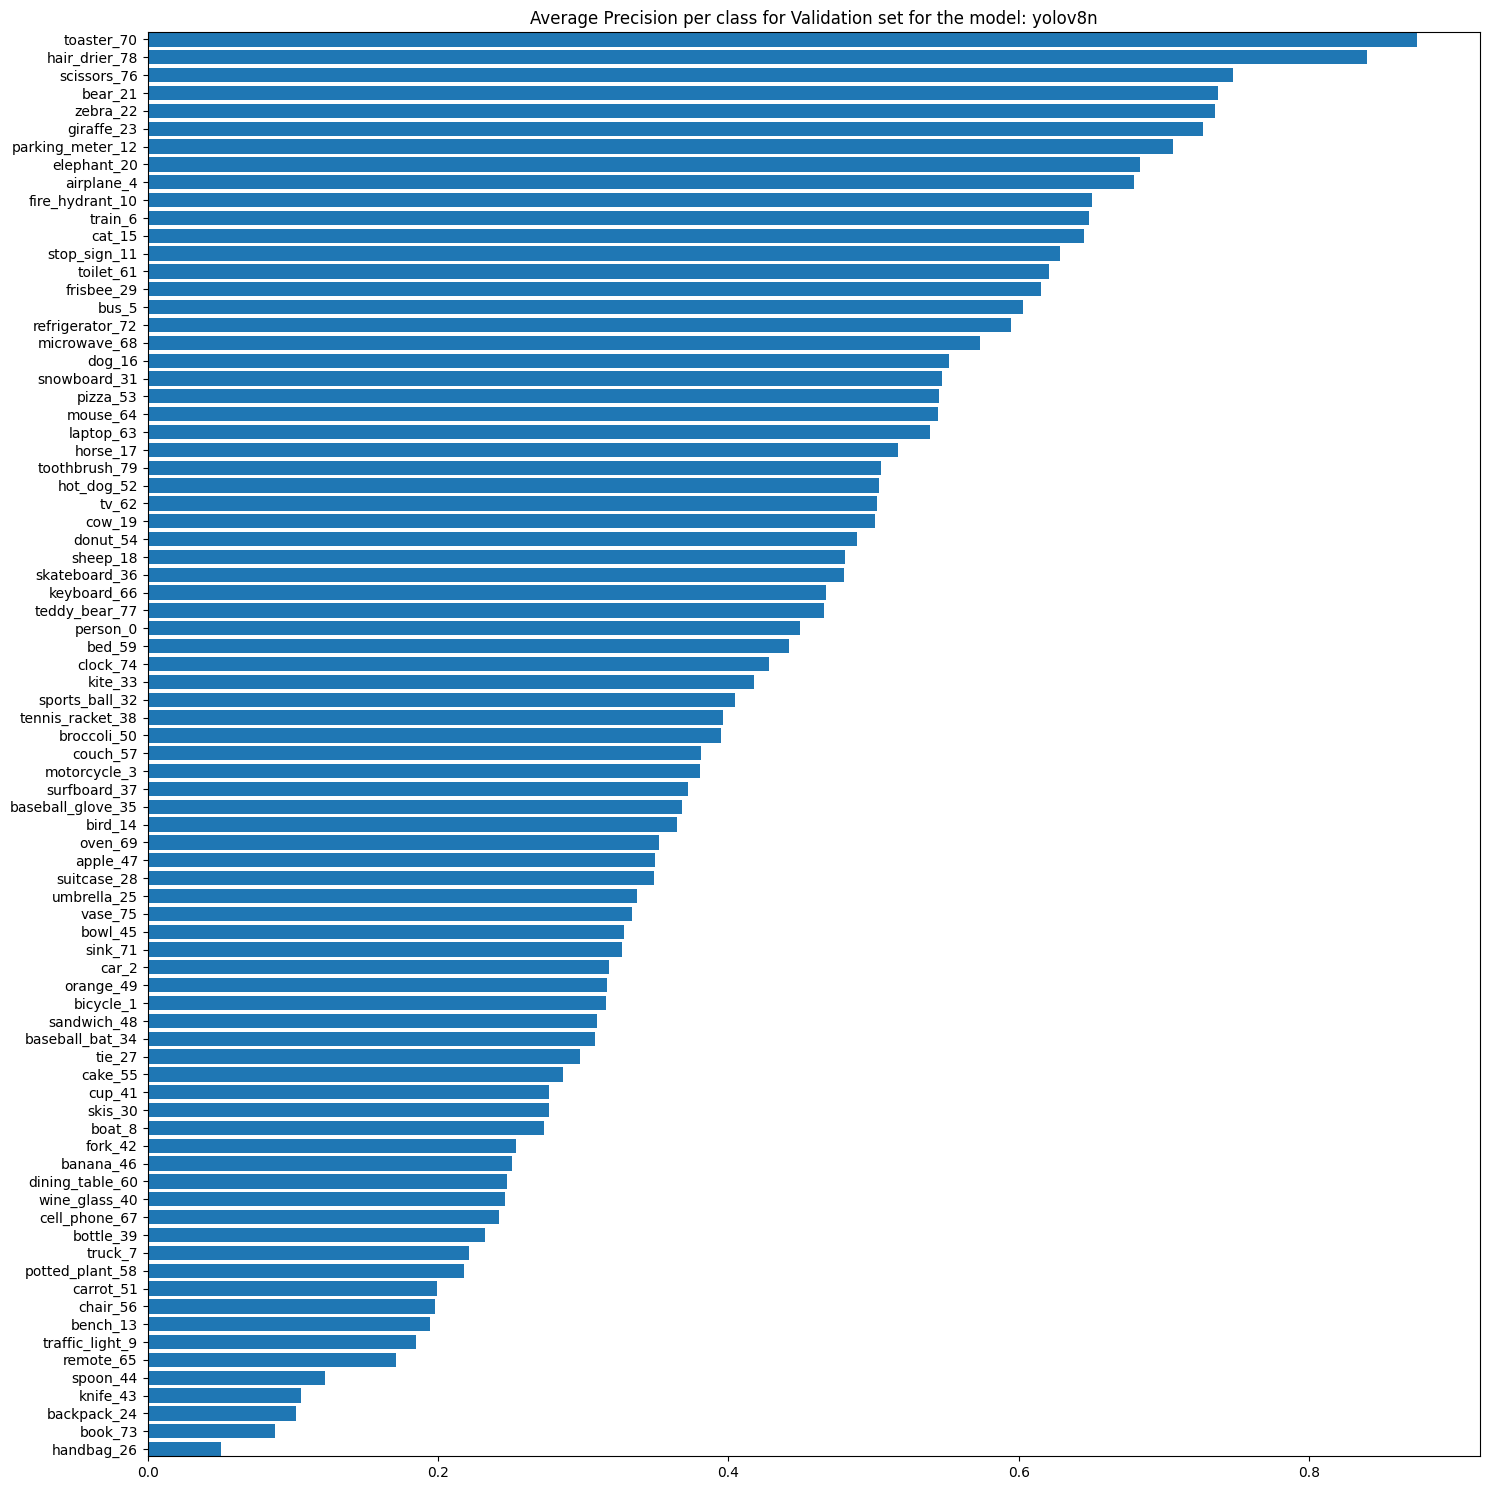

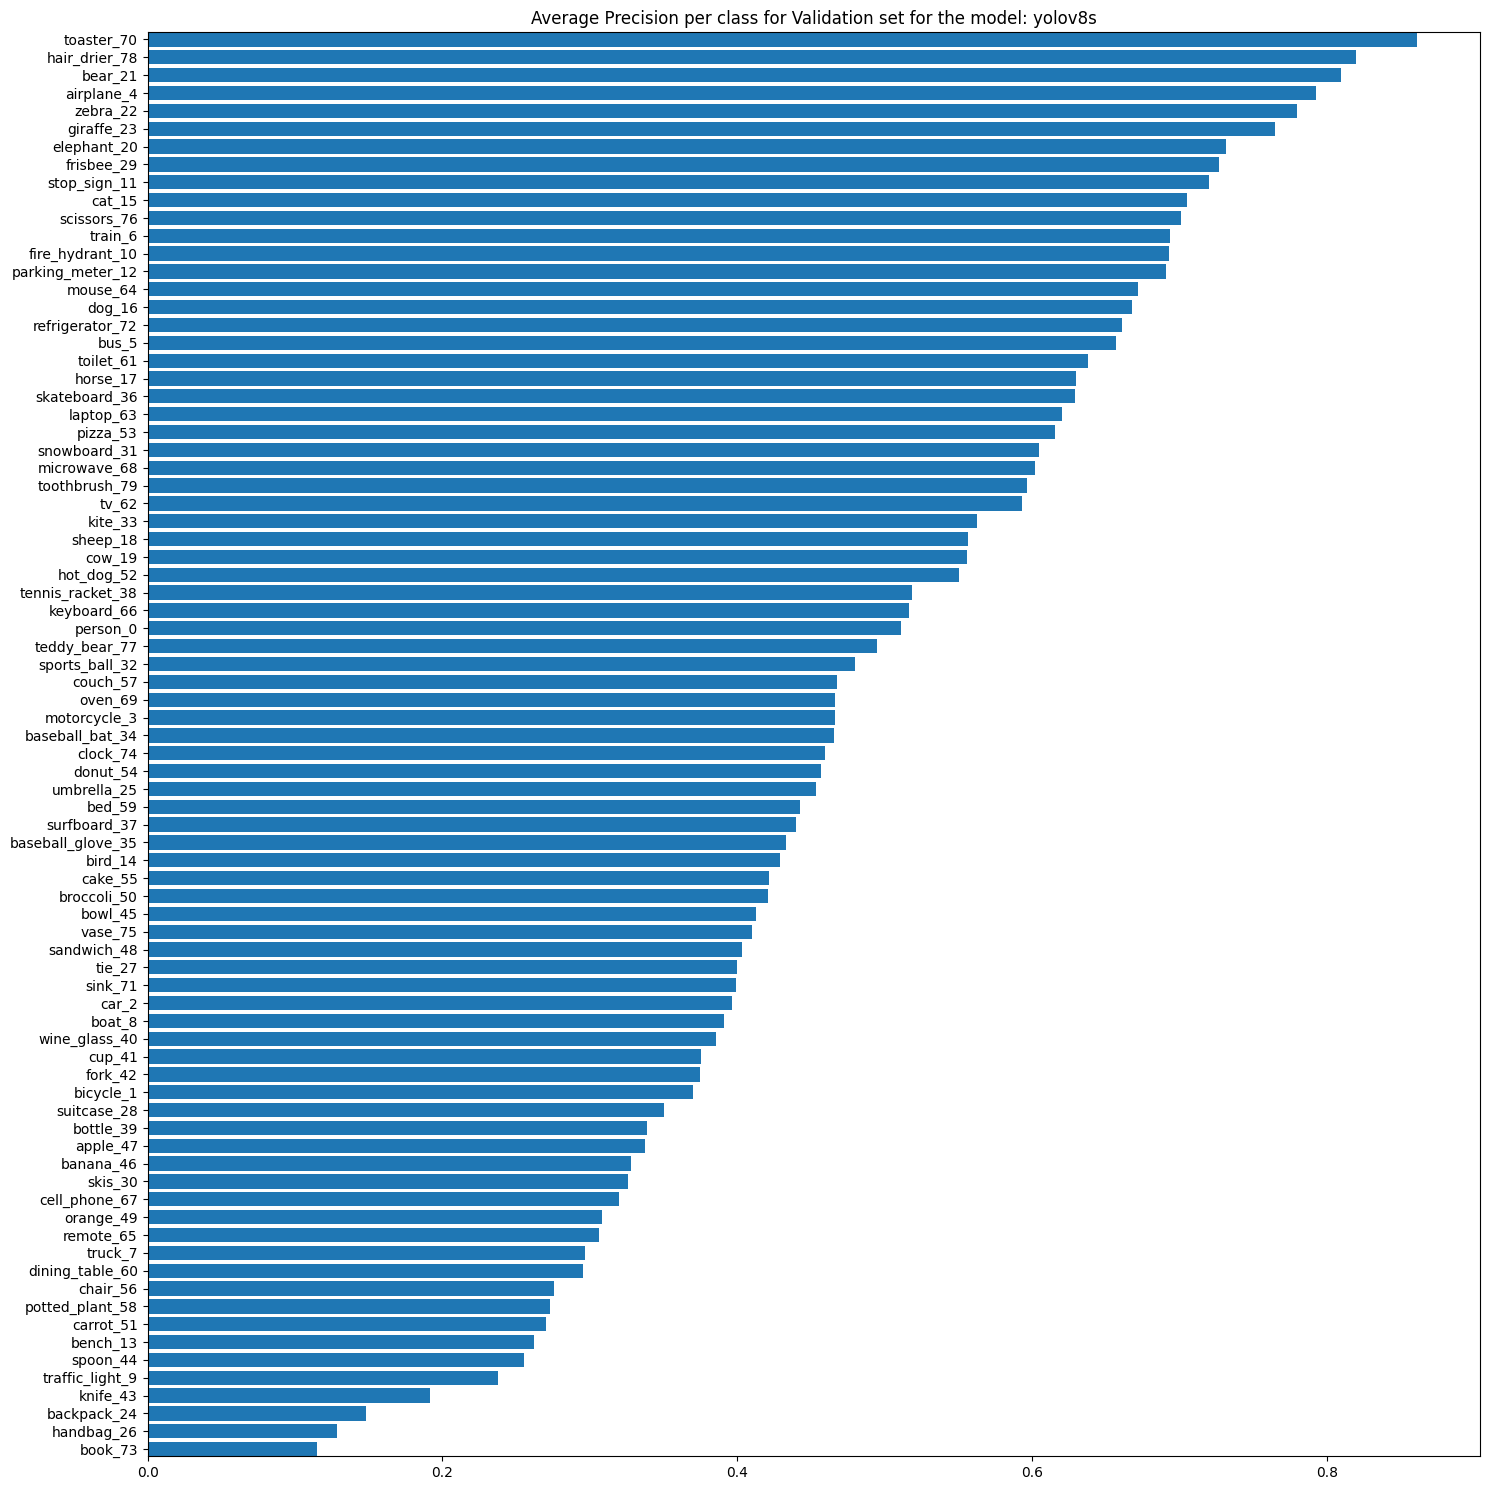

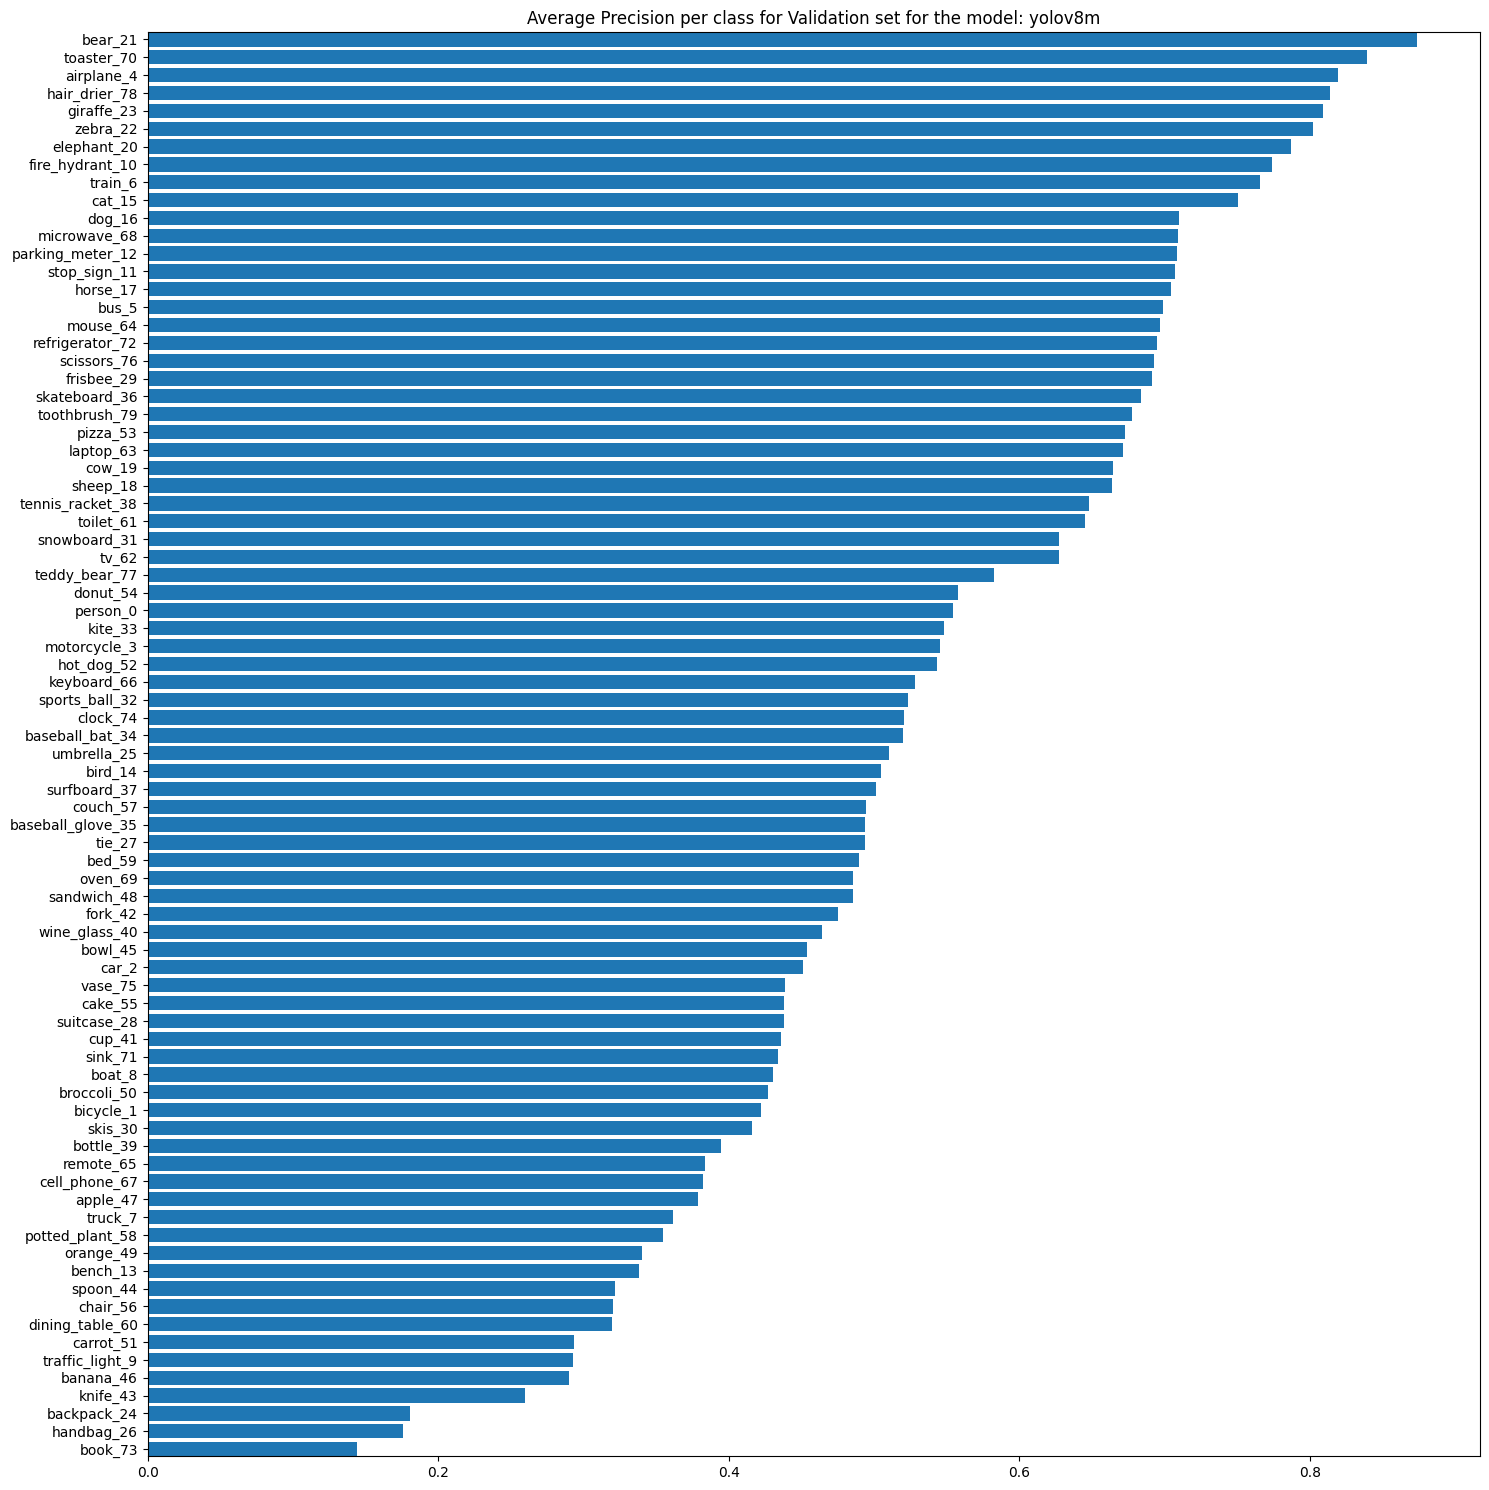

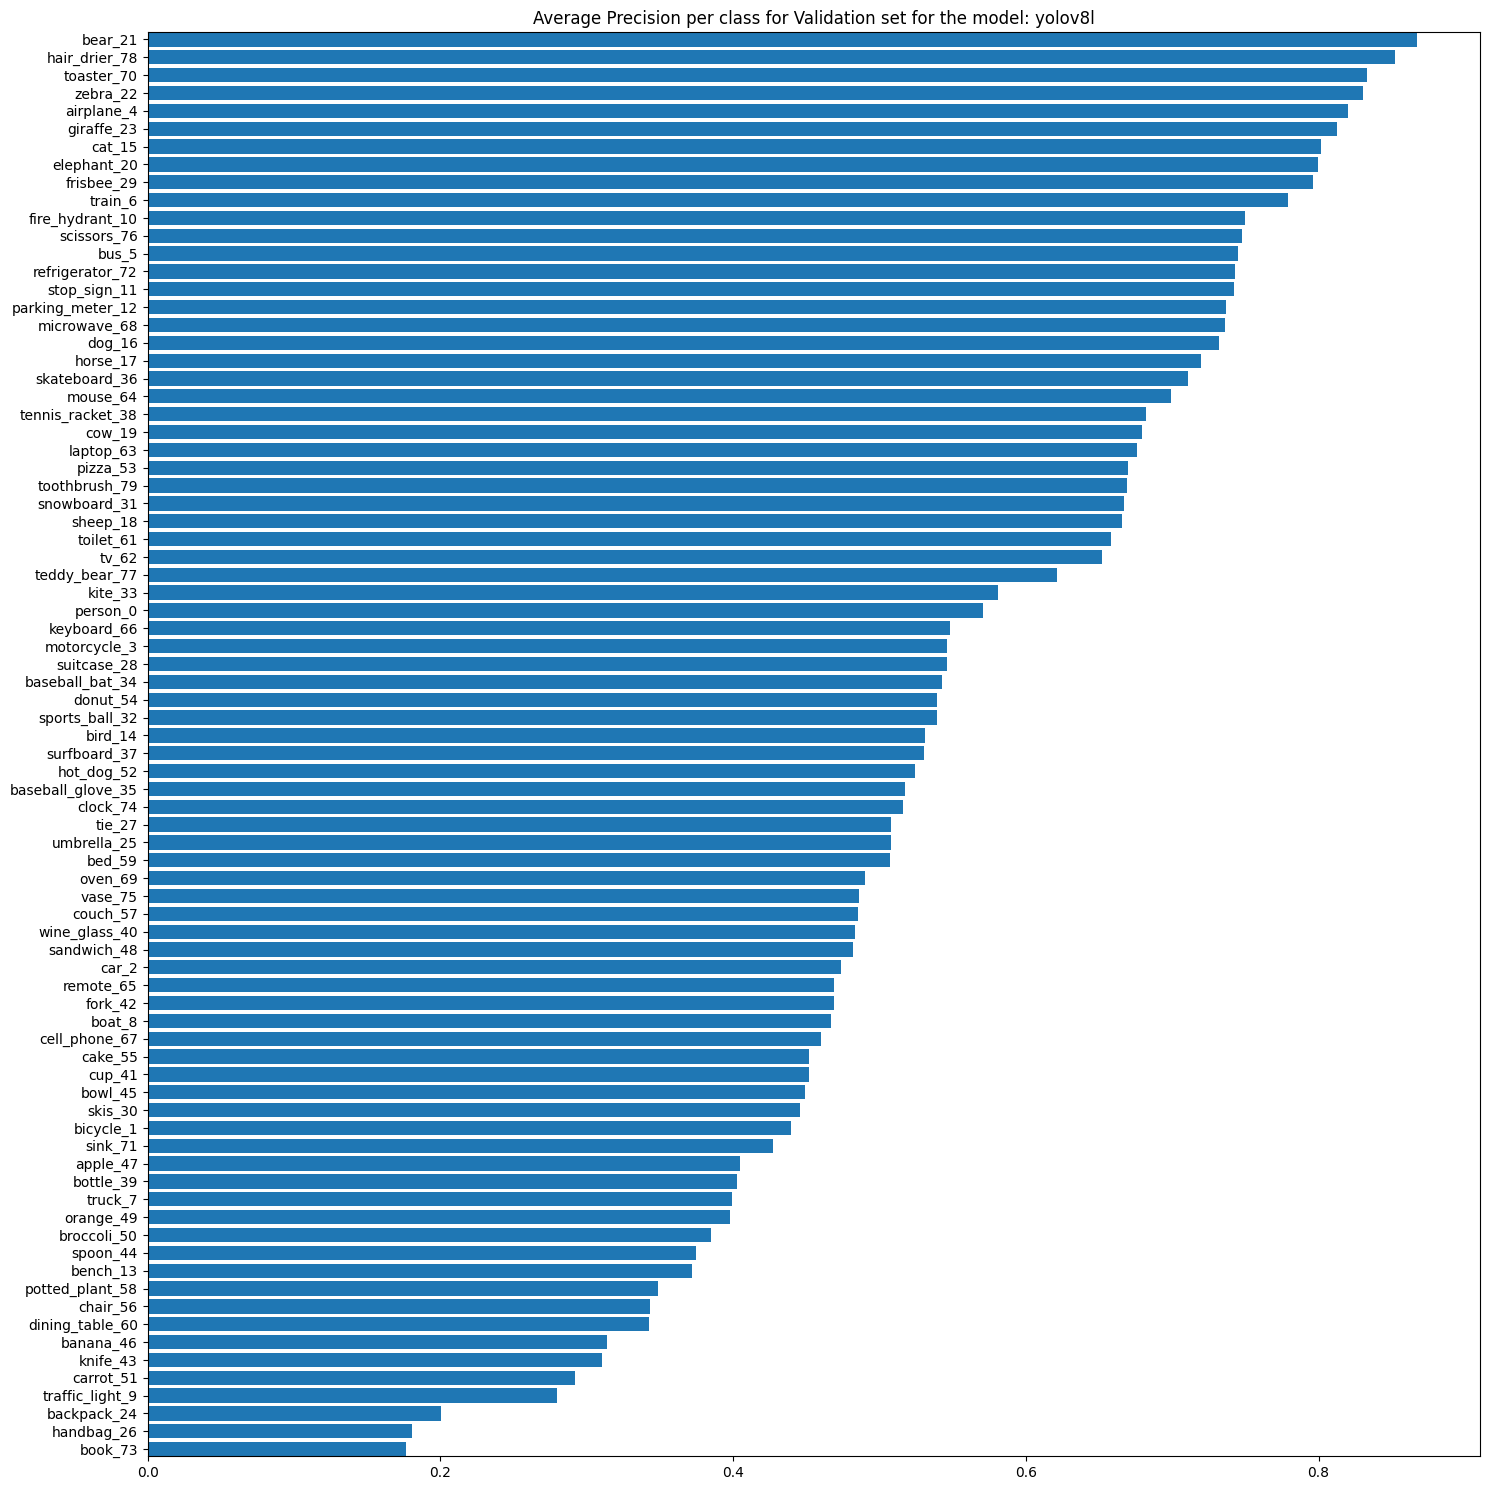

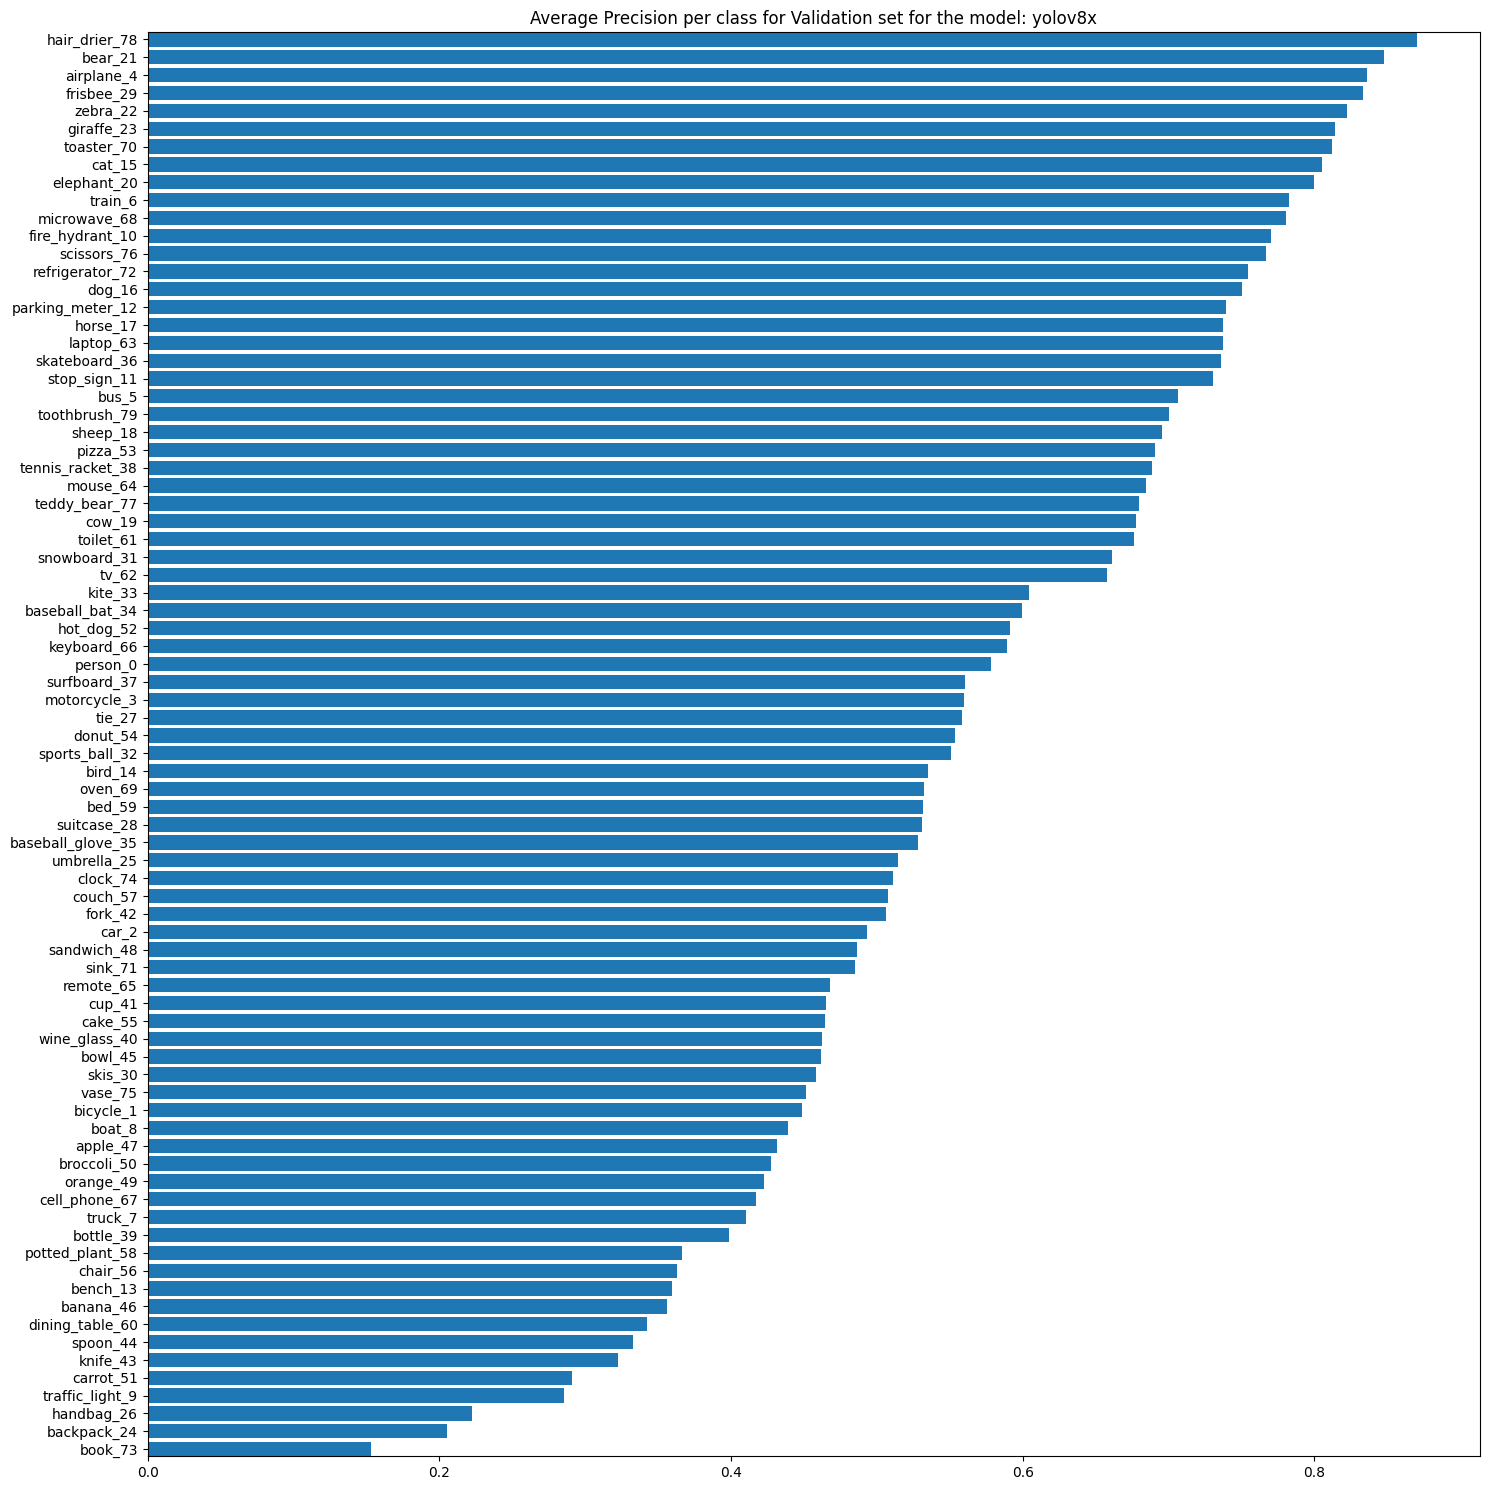

In [24]:
generateBarPlotsForCategories(mAPResultsVal, isTrain=False)

### Conclusion after analysis of bar AP bar plots per category for validation set:
* Here, it can also be seen that there are categories that seem very easy for the models (like hair driers) and some difficult (like book or backpack)
* On the other hand, the categories performing poorer than the others do not make such progress with increasing model complexity as they did in the training set. Their AP increases but not that greatly.
* The location of a certain category on the sorted charts above does not differ much from the results from training set

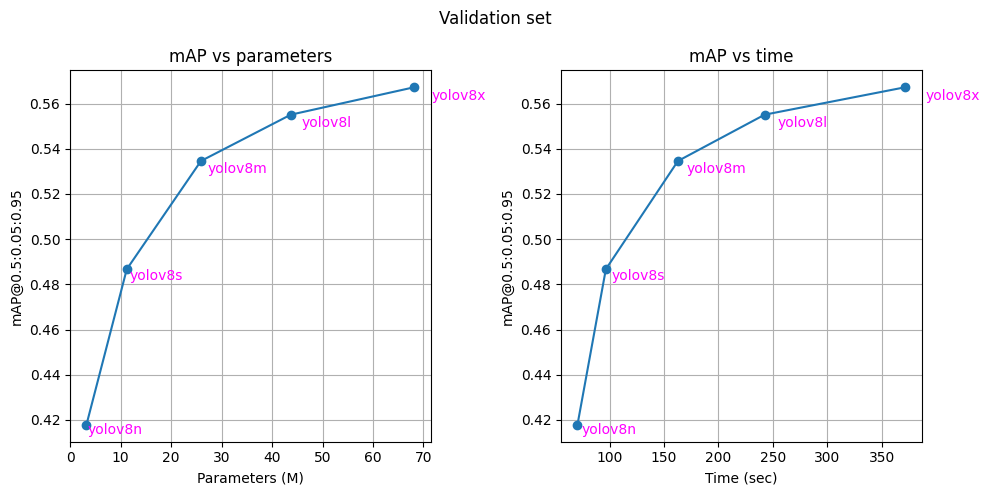

In [25]:
generateLinePlots(parametersDataVal, speedResultsVal, mAPsVal, isTrain=False)

### Conclusions after analysing relation of mAP with parameters and time for training set:
* Although there can be seen similar relation between mAP and model complexity/time, one can see that the curves are a little different for the validation set. The curve does not have 3 parts anymore but it flattens with every model.
* The general trend still stands though. The difference in mAP between v8n and v8s is huge but between v8l and v8x, the choice of the latter would need to be well justified.
* mAP has very similar relation to both parameters and time. The number of parameters and time needed for making predictions are correlated.

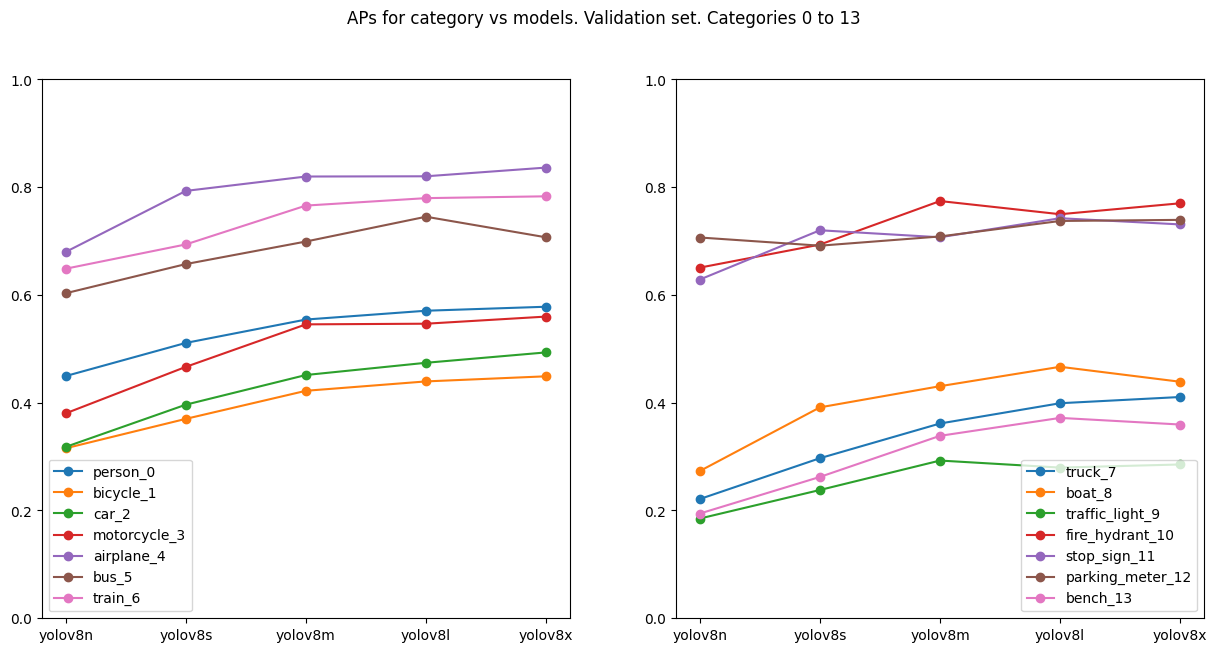

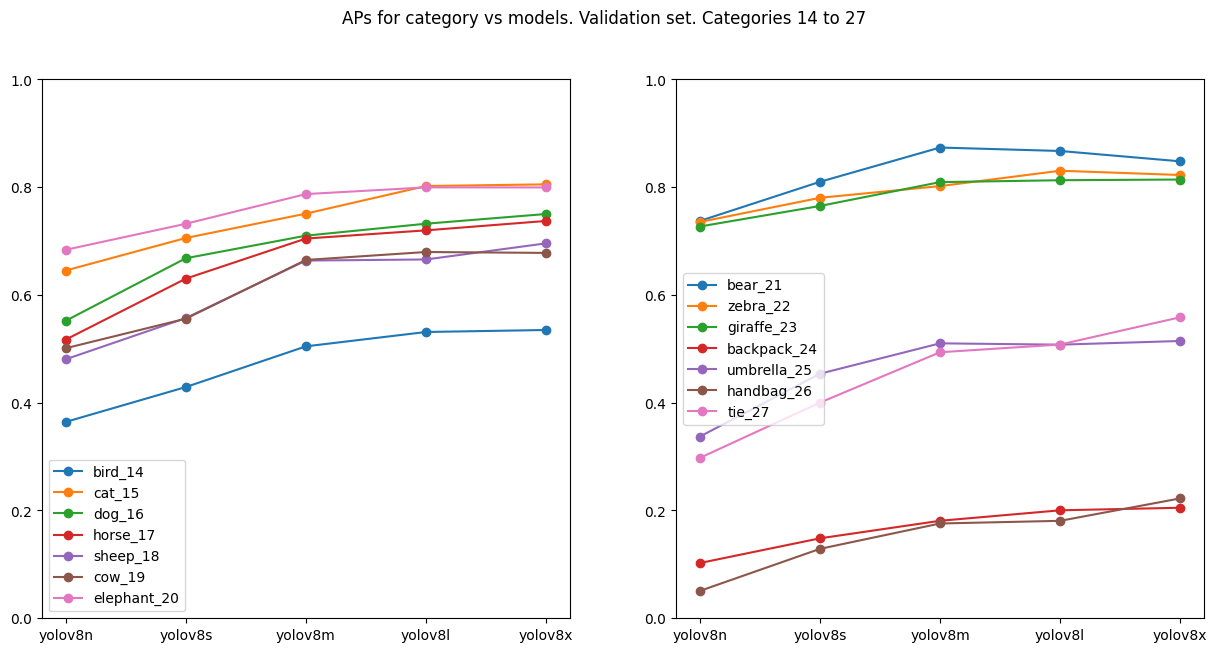

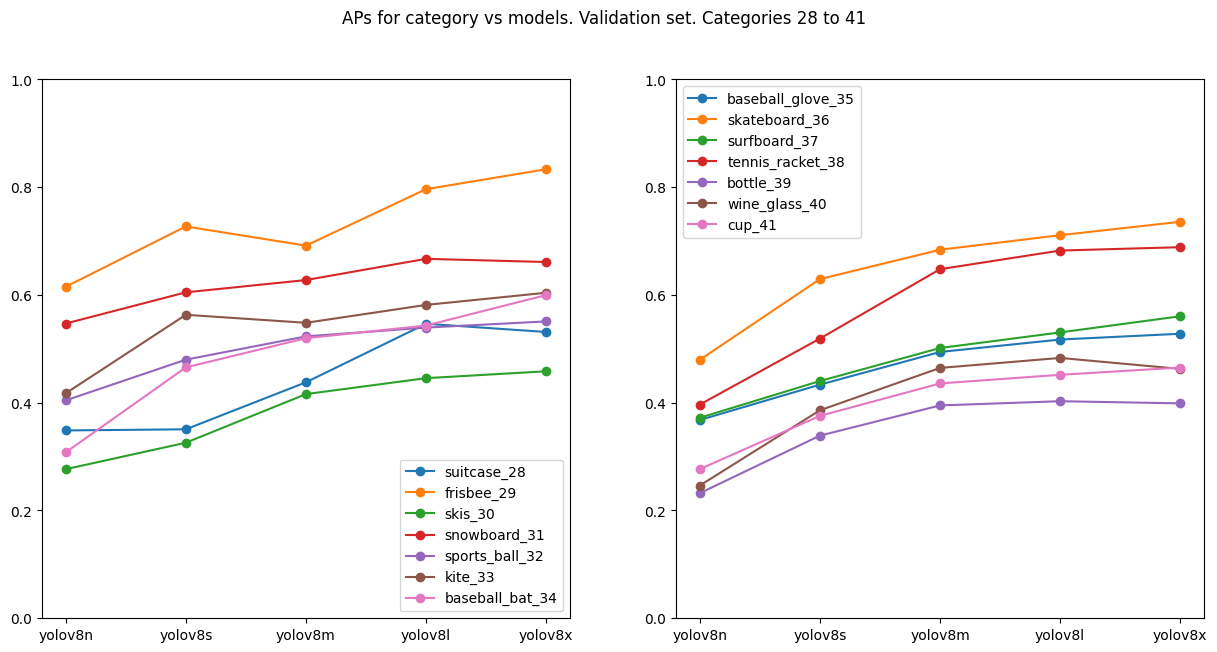

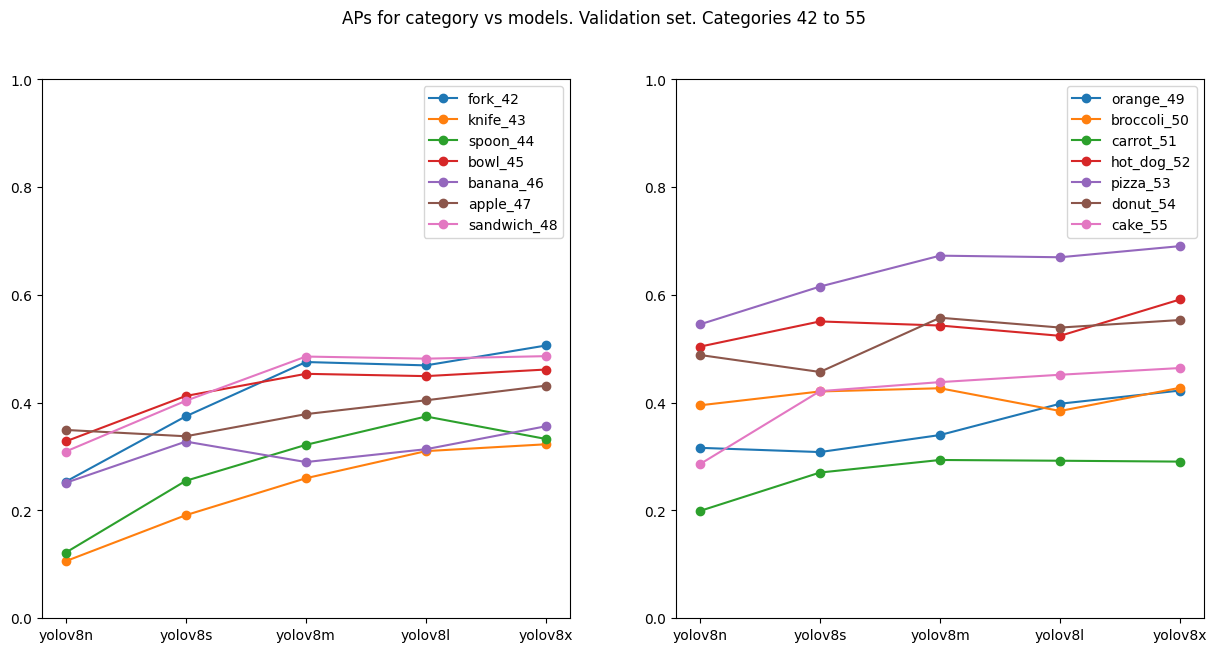

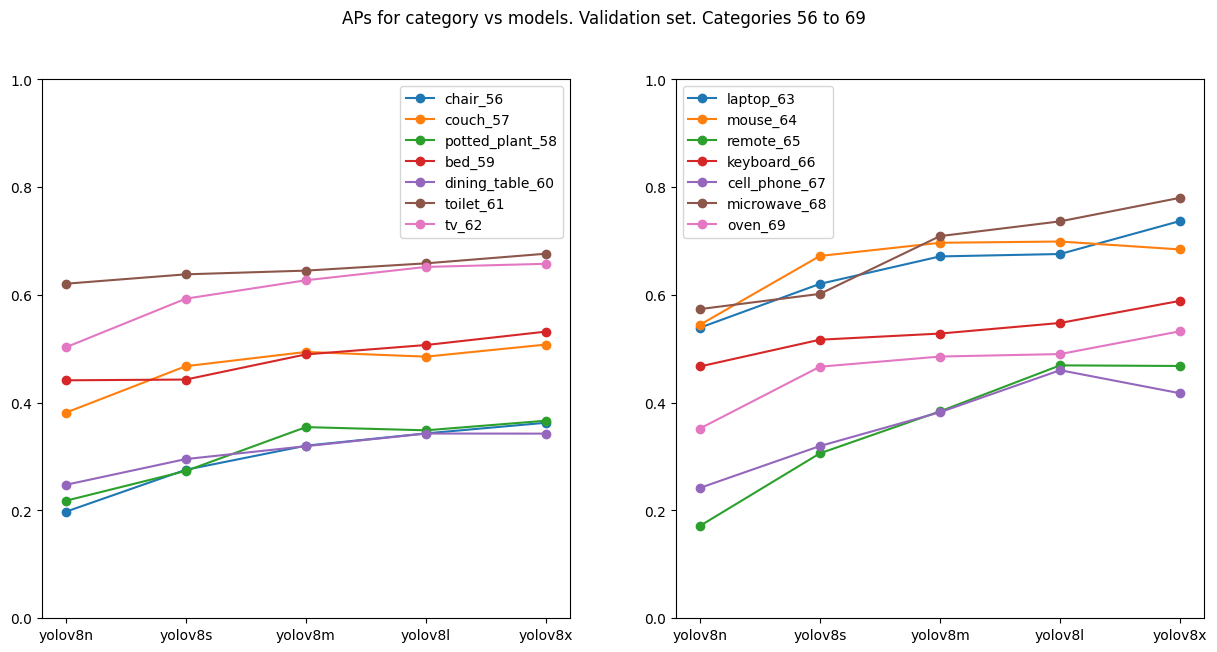

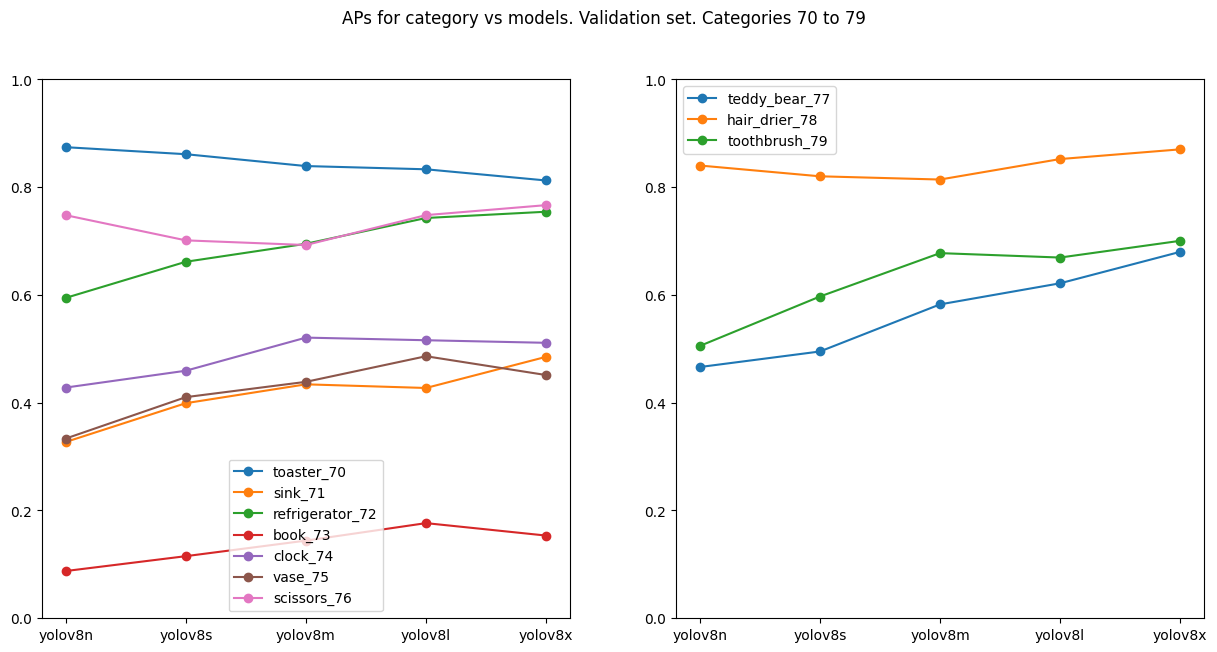

In [26]:
plotLinePlotsForCategories(parametersDataVal, allAPsInOneVal, isTrain=False)

### Conclusions after analysing relation of mAP with parameters and time per class for validation set:
* Most of the categories follow the general trend of mAP increasing alongside model's complexity
* Some categories (like donut_54) do not have the steepest curve between v8n and v8s but for example between v8s and v8m (like the donut category).
* One can observe and interesting result of decreasing mAP with increasing model complexity. For example, for frisbee_29 the model v8m presents worse mAP than for the v8s.
* The strangest result is the toaster_70 category. It has the greatest mAP for the v8n model and the mAP is inversely proportional to the model's complexity! 